## Contents of the Notebook 
#### Started with Species Dataset 
##### Initial steps
- NULL VALUE TREATMENT
- Data Encoding of Categorical data - Used One_hot_encoding using Label_encode might weight and relationship issues
- Outlier treatment
- ##### Model building
     -  Linear Regression Model : Used 78 predictor features (78 columns) | rmse and r2_scoer are bad
     -  Polynomial regression model - rmse and r2_scor are bad.The model's performance is highly inadequate and indicates that something is seriously wrong. The extremely high RMSE and severely negative R² score
- ##### Feature selection
        - Variance Inflation Factor | Though a common classification technique can be used for regression too
        Again, Model building
        Linear Regression Model : Used 8 predictor features (8 columns) | rmse and r2_score are bad
        Polynomial regression model - rmse and r2_scor are bad.The model's performance is highly inadequate and indicates that something is seriously wrong. The extremely high RMSE and severely negative R² score

##### We need more data around species information

#### Phase 2 with SpecAbund data

- Joining the diversity index column from Species data
- NULL VALUE TREATMENT
- Data Encoding of Categorical data - Used One_hot_encoding using Label_encode might weight and relationship issues
- Outlier treatment
- ##### Model building
    - Linear Regression Model : Used 202 predictor features (78 columns) increased by 124 new features | rmse and r2_score are much better 0.091 and 0.3871468654681969 respectively

- ##### Feature selection
      - Used Variance Inflation Factor
        Again, Model building
        Linear Regression Model : Used 158 predictor features (158 columns) | rmse and r2_score still better 0.091 and 0.36 respectively

#### A try on Other techniques

- ##### classification based regressor - KNNregressor - No improvement of the evaluation metrics even after using a classification based regressor
- ##### Ensemble techniques
- ##### classification based ensemble regressor - Random forest regressor - Significant improvement of the evaluation metrics even after using a ensemble based regressor
- ##### classification based ensemble regressor - XBBoost regressor - Significant improvement of the evaluation metrics even after using this ensemble based regressor also
- ##### Voting ensemble Technique
Voting based on linear and knn model - RMSE has decreased to 0.0868, and the R² score has increased to 0.44418.
##### Stacking ensemble technique
The stacking regressor is performing better than the voting regressor model. 
##### we can use the stacking regression technique

#### Increasing the training data sample size to 80% . Improved Results

#### Best Model - A stacking regressor with Linear, Ridge, KNN, Random forest and XGboost regressors as estimators and Ridge regression as Final estimator with a R2 score of 0.758

#### Feature Engineering 

Based on traits data I came up with a logic wherein:
- For any species if the value in fished column =1, then I divided the number by 2 in the related species column of SpecAbund (Considering fished=1 as the species being fished, which will negatively impact the bio diversity)
- For any species if the value in fished column =0, then I multiplied the number by 2 in the related species column of SpecAbund (Considering fished=0 as the species being not fished, which will positively impact the bio diversity)

##### Feature Engineering with traits data - Feature engineering hasn't improved the model performance

#### Data and library import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import seaborn as sns
from scipy import stats
from math import sqrt

import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from sklearn.cluster import KMeans

from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

In [2]:
#to view multiple rows
pd.options.display.max_rows = 999

### Reading data

In [3]:
species_df = pd.read_csv("C://Users/susmi/Documents/ML/Project 2/Data/species.csv",sep=",",index_col=0)

In [4]:
df=species_df

In [5]:
df.head(10)

,site,model,Year,Month,Latitude,Longitude,Depth,Region,Coral_cover,Reef_complexity,...,Pop_per_area_reef_20km,Random,impact,YEAR,HABITAT_CD,REGION,PCT_CORAL,MAX_HARD_RELIEF,no.divers,Diversity_index
0,4733520_128U,biomass,2005,August,24.446433,-81.962900,9.800000,FLA KEYS,2.000000,0.550322,...,0.047128,3786,0.205,2005,ISOL_LR,FLA KEYS,2.000000,0.550322,4,0.877755
1,4966028_487U,impact,2005,June,24.461130,-81.840099,8.821212,FLA KEYS,6.181818,1.886364,...,0.403795,503,0.382,2005,SPGR_HR,FLA KEYS,6.181818,1.886364,4,0.912085
2,4981032_102U,biomass,2005,July,24.467250,-81.832367,17.399239,FLA KEYS,7.506345,0.749873,...,0.392888,3430,NaN,2005,CONT_LR,FLA KEYS,7.506345,0.749873,4,0.882112
3,4999782_141U,impact,2005,August,24.468767,-81.822167,9.200000,FLA KEYS,10.000000,0.400000,...,0.386919,3696,NaN,2005,ISOL_LR,FLA KEYS,10.000000,0.400000,4,0.806049
4,5026033_475U,impact,2005,June,24.470206,-81.808148,8.558032,FLA KEYS,2.870486,0.289415,...,0.383887,4090,NaN,2005,ISOL_LR,FLA KEYS,2.870486,0.289415,4,0.829156
5,5067281_105U,biomass,2005,July,24.466283,-81.786533,26.504821,FLA KEYS,17.620519,1.200000,...,0.408742,7886,0.382,2005,SPGR_LR,FLA KEYS,17.620519,1.200000,4,0.826781
6,5157285_104U,impact,2005,July,24.474067,-81.739067,8.696966,FLA KEYS,25.018963,1.149431,...,0.389774,3052,NaN,2005,SPGR_LR,FLA KEYS,25.018963,1.149431,4,0.934887
7,5168534_472U,biomass,2005,June,24.471833,-81.733867,20.300000,FLA KEYS,6.000000,1.300000,...,0.391648,8192,NaN,2005,SPGR_LR,FLA KEYS,6.000000,1.300000,2,0.853695
8,5187287_495U,biomass,2005,June,24.477337,-81.722680,20.463554,FLA KEYS,9.817768,1.700000,...,0.380080,8662,0.382,2005,SPGR_LR,FLA KEYS,9.817768,1.700000,4,0.837965
9,5194788_112U,biomass,2005,July,24.479050,-81.718833,9.500000,FLA KEYS,2.493606,0.849361,...,0.375463,1990,NaN,2005,SPGR_HR,FLA KEYS,2.493606,0.849361,4,0.890591


In [6]:
df.count()

site                           3999
model                          3999
Year                           3999
Month                          3999
Latitude                       3999
Longitude                      3999
Depth                          3999
Region                         3999
Coral_cover                    3292
Reef_complexity                3292
SST                            3999
NPP                            3999
Wave_exposure                  3999
Habitat_type_classLV0          3999
Habitat_type_classLV2          3999
Coral_area_UFRTM_20km          3999
Coral_area_UFRTM_200km         3999
Depth_Sbrocco                  3999
Deepwater                      3999
FSA                            3999
Marina_slips_10km              3999
Marina_slips_25km              3999
Marine_reserve                 3999
Population_20km                3999
Population_50km                3999
Recreational_fishermen_50km    3999
Tourist_fishing                3999
Artificial_reefs_1km        

### Unquie data check

In [7]:
df.nunique()

site                           3999
model                             2
Year                             12
Month                             8
Latitude                       3984
Longitude                      3969
Depth                          3293
Region                            3
Coral_cover                    2414
Reef_complexity                2814
SST                            3428
NPP                            3660
Wave_exposure                  3673
Habitat_type_classLV0             3
Habitat_type_classLV2             8
Coral_area_UFRTM_20km          3253
Coral_area_UFRTM_200km         3608
Depth_Sbrocco                    64
Deepwater                       787
FSA                            3065
Marina_slips_10km               543
Marina_slips_25km               508
Marine_reserve                    2
Population_20km                1051
Population_50km                1039
Recreational_fishermen_50km    1009
Tourist_fishing                1800
Artificial_reefs_1km        

In [8]:
# Dropping columns with only 1 unique valuess
df1=df.drop(columns=['FKNMS','DryTortugas','BNP','CoralECA','Total_gravity_intercept','Keys_Divisions'])

In [9]:
# Type of data
print(df1.dtypes)

site                            object
model                           object
Year                             int64
Month                           object
Latitude                       float64
Longitude                      float64
Depth                          float64
Region                          object
Coral_cover                    float64
Reef_complexity                float64
SST                            float64
NPP                            float64
Wave_exposure                  float64
Habitat_type_classLV0           object
Habitat_type_classLV2           object
Coral_area_UFRTM_20km            int64
Coral_area_UFRTM_200km           int64
Depth_Sbrocco                  float64
Deepwater                      float64
FSA                            float64
Marina_slips_10km                int64
Marina_slips_25km                int64
Marine_reserve                  object
Population_20km                  int64
Population_50km                  int64
Recreational_fishermen_50

### Descriptive Statistics/ Statistical Analysis

In [10]:
df1.describe()

,Year,Latitude,Longitude,Depth,Coral_cover,Reef_complexity,SST,NPP,Wave_exposure,Coral_area_UFRTM_20km,...,Rec_reliance,Commercial_pounds_landed,Pop_per_area_reef_20km,Random,impact,YEAR,PCT_CORAL,MAX_HARD_RELIEF,no.divers,Diversity_index
count,3999.000000,3999.000000,3999.000000,3999.000000,3292.000000,3292.000000,3999.000000,3999.000000,3999.000000,3999.000000,...,3910.000000,3.998000e+03,3999.000000,3999.000000,2779.000000,3999.000000,3292.000000,3292.000000,3999.000000,3999.000000
mean,2012.886222,25.361813,-80.912910,12.031226,4.549820,1.100154,23.760696,523.320811,7.322459,76727.255314,...,0.424433,6.312866e+05,6.386781,5047.471618,0.400637,2012.886222,4.549820,1.100154,3.115779,0.831469
std,3.629448,0.806724,1.051129,6.942690,5.522744,0.851008,0.552442,163.404174,0.211270,44693.794158,...,2.247541,4.861803e+05,11.092795,2919.598275,0.281552,3.629448,5.522744,0.851008,0.998422,0.114777
min,2005.000000,24.431943,-82.986818,1.300482,0.000000,0.075887,22.405206,287.664307,5.213092,12257.000000,...,-0.185000,1.706314e+05,0.000000,1.000000,0.000000,2005.000000,0.000000,0.075887,2.000000,0.000000
25%,2011.000000,24.632586,-81.695419,6.351316,1.500000,0.500000,23.608484,365.925385,7.294437,50594.000000,...,-0.185000,2.469954e+05,0.039136,2550.500000,0.174000,2011.000000,1.500000,0.500000,2.000000,0.811582
50%,2013.000000,25.123213,-80.292226,10.171806,2.758143,0.900596,23.929285,533.677063,7.368210,60682.000000,...,-0.185000,3.180504e+05,0.248873,5097.000000,0.382000,2013.000000,2.758143,0.900596,4.000000,0.867035
75%,2016.000000,26.034196,-80.092946,17.148568,5.283544,1.448243,24.200861,632.628479,7.455595,91516.000000,...,0.044000,8.556702e+05,12.681632,7602.000000,0.694000,2016.000000,5.283544,1.448243,4.000000,0.900148
max,2018.000000,27.189445,-79.993800,32.295441,55.000000,10.538338,24.436212,1330.589233,7.597482,280125.000000,...,12.140000,1.511066e+06,55.371104,9997.000000,1.000000,2018.000000,55.000000,10.538338,8.000000,0.956324


### Identifying and treating the null values

In [11]:
#display column with null values
df1.isna().sum()

site                              0
model                             0
Year                              0
Month                             0
Latitude                          0
Longitude                         0
Depth                             0
Region                            0
Coral_cover                     707
Reef_complexity                 707
SST                               0
NPP                               0
Wave_exposure                     0
Habitat_type_classLV0             0
Habitat_type_classLV2             0
Coral_area_UFRTM_20km             0
Coral_area_UFRTM_200km            0
Depth_Sbrocco                     0
Deepwater                         0
FSA                               0
Marina_slips_10km                 0
Marina_slips_25km                 0
Marine_reserve                    0
Population_20km                   0
Population_50km                   0
Recreational_fishermen_50km       0
Tourist_fishing                   0
Artificial_reefs_1km        

In [12]:
#NULL VALUE TREATMENT
df1.loc[df1["Commercial_pounds_landed"].isna(),"Commercial_pounds_landed"] = df1.Commercial_pounds_landed.mean()
for nod in [2, 4, 6]:
    # Calculate mean Coral_cover for the given no.divers and Habitat_type_classLV0
    mean_coral_cover = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "Coral_cover"
    ].mean()
    mean_reef_complexity = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "Reef_complexity"
    ].mean()
    mean_connectivity = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "connectivity"
    ].mean()
    mean_total_gravity = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "Total_gravity"
    ].mean()
    mean_comm_engagement = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "Comm_engagement"
    ].mean()
    mean_comm_reliance = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "Comm_reliance"
    ].mean()
    mean_rec_engagement = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "Rec_engagement"
    ].mean()
    mean_rec_reliance = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "Rec_reliance"
    ].mean()
    mean_impact_sefcri = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "impact"
    ].mean()
    mean_impact_flakeys = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "FLA KEYS"),
        "impact"
    ].mean()
    mean_impact_drytort = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "DRY TORT"),
        "impact"
    ].mean()
    mean_pct_coral = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "PCT_CORAL"
    ].mean()
    mean_max_hard_relief = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "MAX_HARD_RELIEF"
    ].mean()
    
    # Fill missing Coral_cover values
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["Coral_cover"].isna(),
        "Coral_cover"
    ] = mean_coral_cover
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["Reef_complexity"].isna(),
        "Reef_complexity"
    ] = mean_reef_complexity
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["connectivity"].isna(),
        "connectivity"
    ] = mean_connectivity
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["Total_gravity"].isna(),
        "Total_gravity"
    ] = mean_total_gravity
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
        df1["Comm_engagement"].isna(),
        "Comm_engagement"
    ] = mean_comm_engagement
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
        df1["Comm_reliance"].isna(),
        "Comm_reliance"
    ] = mean_comm_reliance
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
        df1["Rec_engagement"].isna(),
        "Rec_engagement"
    ] = mean_rec_engagement
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & df1["Rec_reliance"].isna(),"Rec_reliance"
    ] = mean_rec_reliance
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
		(df1["Region"] == "SEFCRI") & 
        df1["impact"].isna(),
        "impact"
    ] = mean_impact_sefcri
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
		(df1["Region"] == "FLA KEYS") & 
        df1["impact"].isna(),
        "impact"
    ] = mean_impact_flakeys
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
		(df1["Region"] == "DRY TORT") & 
        df1["impact"].isna(),
        "impact"
    ] = mean_impact_drytort
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["PCT_CORAL"].isna(),
        "PCT_CORAL"
    ] = mean_pct_coral
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["MAX_HARD_RELIEF"].isna(),
        "MAX_HARD_RELIEF"
    ] = mean_max_hard_relief

In [13]:
df1.isna().sum()

site                           0
model                          0
Year                           0
Month                          0
Latitude                       0
Longitude                      0
Depth                          0
Region                         0
Coral_cover                    0
Reef_complexity                0
SST                            0
NPP                            0
Wave_exposure                  0
Habitat_type_classLV0          0
Habitat_type_classLV2          0
Coral_area_UFRTM_20km          0
Coral_area_UFRTM_200km         0
Depth_Sbrocco                  0
Deepwater                      0
FSA                            0
Marina_slips_10km              0
Marina_slips_25km              0
Marine_reserve                 0
Population_20km                0
Population_50km                0
Recreational_fishermen_50km    0
Tourist_fishing                0
Artificial_reefs_1km           0
SG_permits_50km                0
SG_charter_permits_25km        0
Total_grav

### Data encoding

Data Encoding refers to the converting of categorical variables into numerical representations that can be understood by machine learning algorithms. Common techniques include one-hot encoding, label encoding, or ordinal encoding.

We are not using label encoding as Label encoding process assigns integer values to categories based on their order of appearance in the dataset. This can mislead the algorithm into assuming a natural ordering or relationship between the categories when, in fact, there may be no such relationship.

The . get_dummies() function creates dummy (indicator) variables from categorical variables. Each level of the categorical variable gets its own column - a dummy variable. The dummy variables take on the value “1” if the original categorical variable was that level or “0” if not. And it is better to use get dummies in this problem. 

In [14]:
#removing site column as it is the index
df1 = df1.drop(columns=['site'])
df1 = df1.drop(df1.columns[-5], axis=1)

In [15]:
# get_dummies tranforms categorical data to numbers

region_dummies = pd.get_dummies(df1.Region, drop_first=True, dtype=int)
# Concatenate the dummy variables with the original DataFrame
df1 = pd.concat([df1, region_dummies], axis=1)
# Drop the original 'Region' column if desired
df1.drop(columns=["Region"], inplace=True)

model_dummies = pd.get_dummies(df1.model, drop_first=True, dtype=int)
df1 = pd.concat([df1, model_dummies], axis=1)
df1.drop(columns=["model"], inplace=True)

Month_dummies = pd.get_dummies(df1.Month, drop_first=True, dtype=int)
df1 = pd.concat([df1, Month_dummies], axis=1)
df1.drop(columns=["Month"], inplace=True)

HABITAT_CD_dummies = pd.get_dummies(df1.HABITAT_CD, drop_first=True, dtype=int)
df1 = pd.concat([df1, HABITAT_CD_dummies], axis=1)
df1.drop(columns=["HABITAT_CD"], inplace=True)

Habitat_type_classLV0_dummies = pd.get_dummies(df1.Habitat_type_classLV0, drop_first=True, dtype=int)
df1 = pd.concat([df1, Habitat_type_classLV0_dummies], axis=1)
df1.drop(columns=["Habitat_type_classLV0"], inplace=True)

Habitat_type_classLV2_dummies = pd.get_dummies(df1.Habitat_type_classLV2, drop_first=True, dtype=int)
df1 = pd.concat([df1, Habitat_type_classLV2_dummies], axis=1)
df1.drop(columns=["Habitat_type_classLV2"], inplace=True)

Marine_reserve_dummies = pd.get_dummies(df1.Marine_reserve, drop_first=True, dtype=int)
df1 = pd.concat([df1, Marine_reserve_dummies], axis=1)
df1.drop(columns=["Marine_reserve"], inplace=True)

### Correlation Matrix

A correlation matrix is just a table with the correlation coefficients for different variables. The matrix shows how all the possible pairs of values in a table are related to each other. It is a powerful tool for summarizing a large data set and finding and showing patterns in the data.

It is often shown as a table, with each variable listed in both the rows and the columns and the correlation coefficient between each pair of variables written in each cell. The correlation coefficient ranges from -1 to +1, where -1 means a perfect negative correlation, +1 means a perfect positive correlation, and 0 means there is no correlation between the variables.

In [16]:
df2=df1.corr()

In [17]:
df2.Diversity_index

Year                                   0.039844
Latitude                              -0.049113
Longitude                              0.087126
Depth                                 -0.207735
Coral_cover                           -0.132432
Reef_complexity                       -0.137309
SST                                    0.151907
NPP                                   -0.048109
Wave_exposure                         -0.067864
Coral_area_UFRTM_20km                  0.044208
Coral_area_UFRTM_200km                 0.150167
Depth_Sbrocco                          0.121668
Deepwater                             -0.037910
FSA                                   -0.059314
Marina_slips_10km                      0.058860
Marina_slips_25km                      0.106543
Population_20km                        0.045993
Population_50km                        0.066104
Recreational_fishermen_50km            0.070398
Tourist_fishing                        0.095875
Artificial_reefs_1km                   0

#### Correlation heatmap

<Axes: >

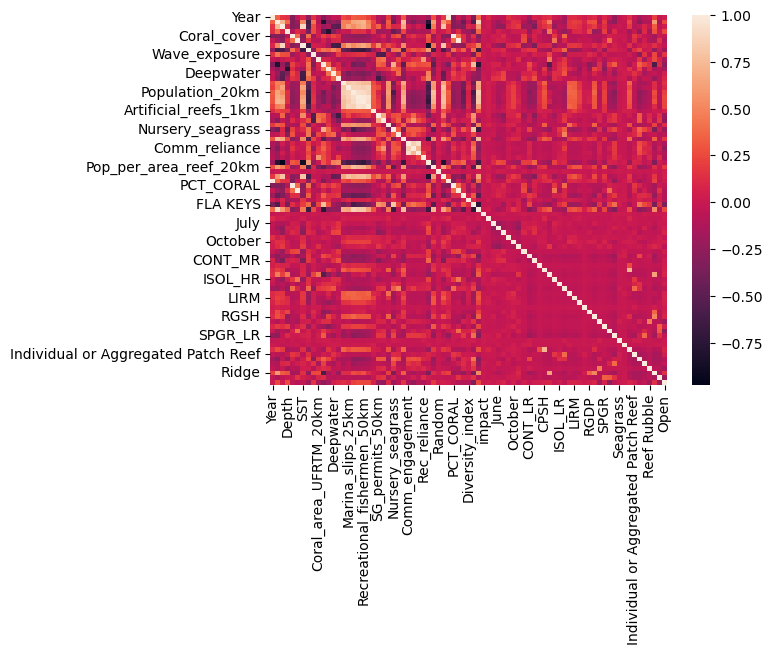

In [18]:
sns.heatmap(df1.corr())

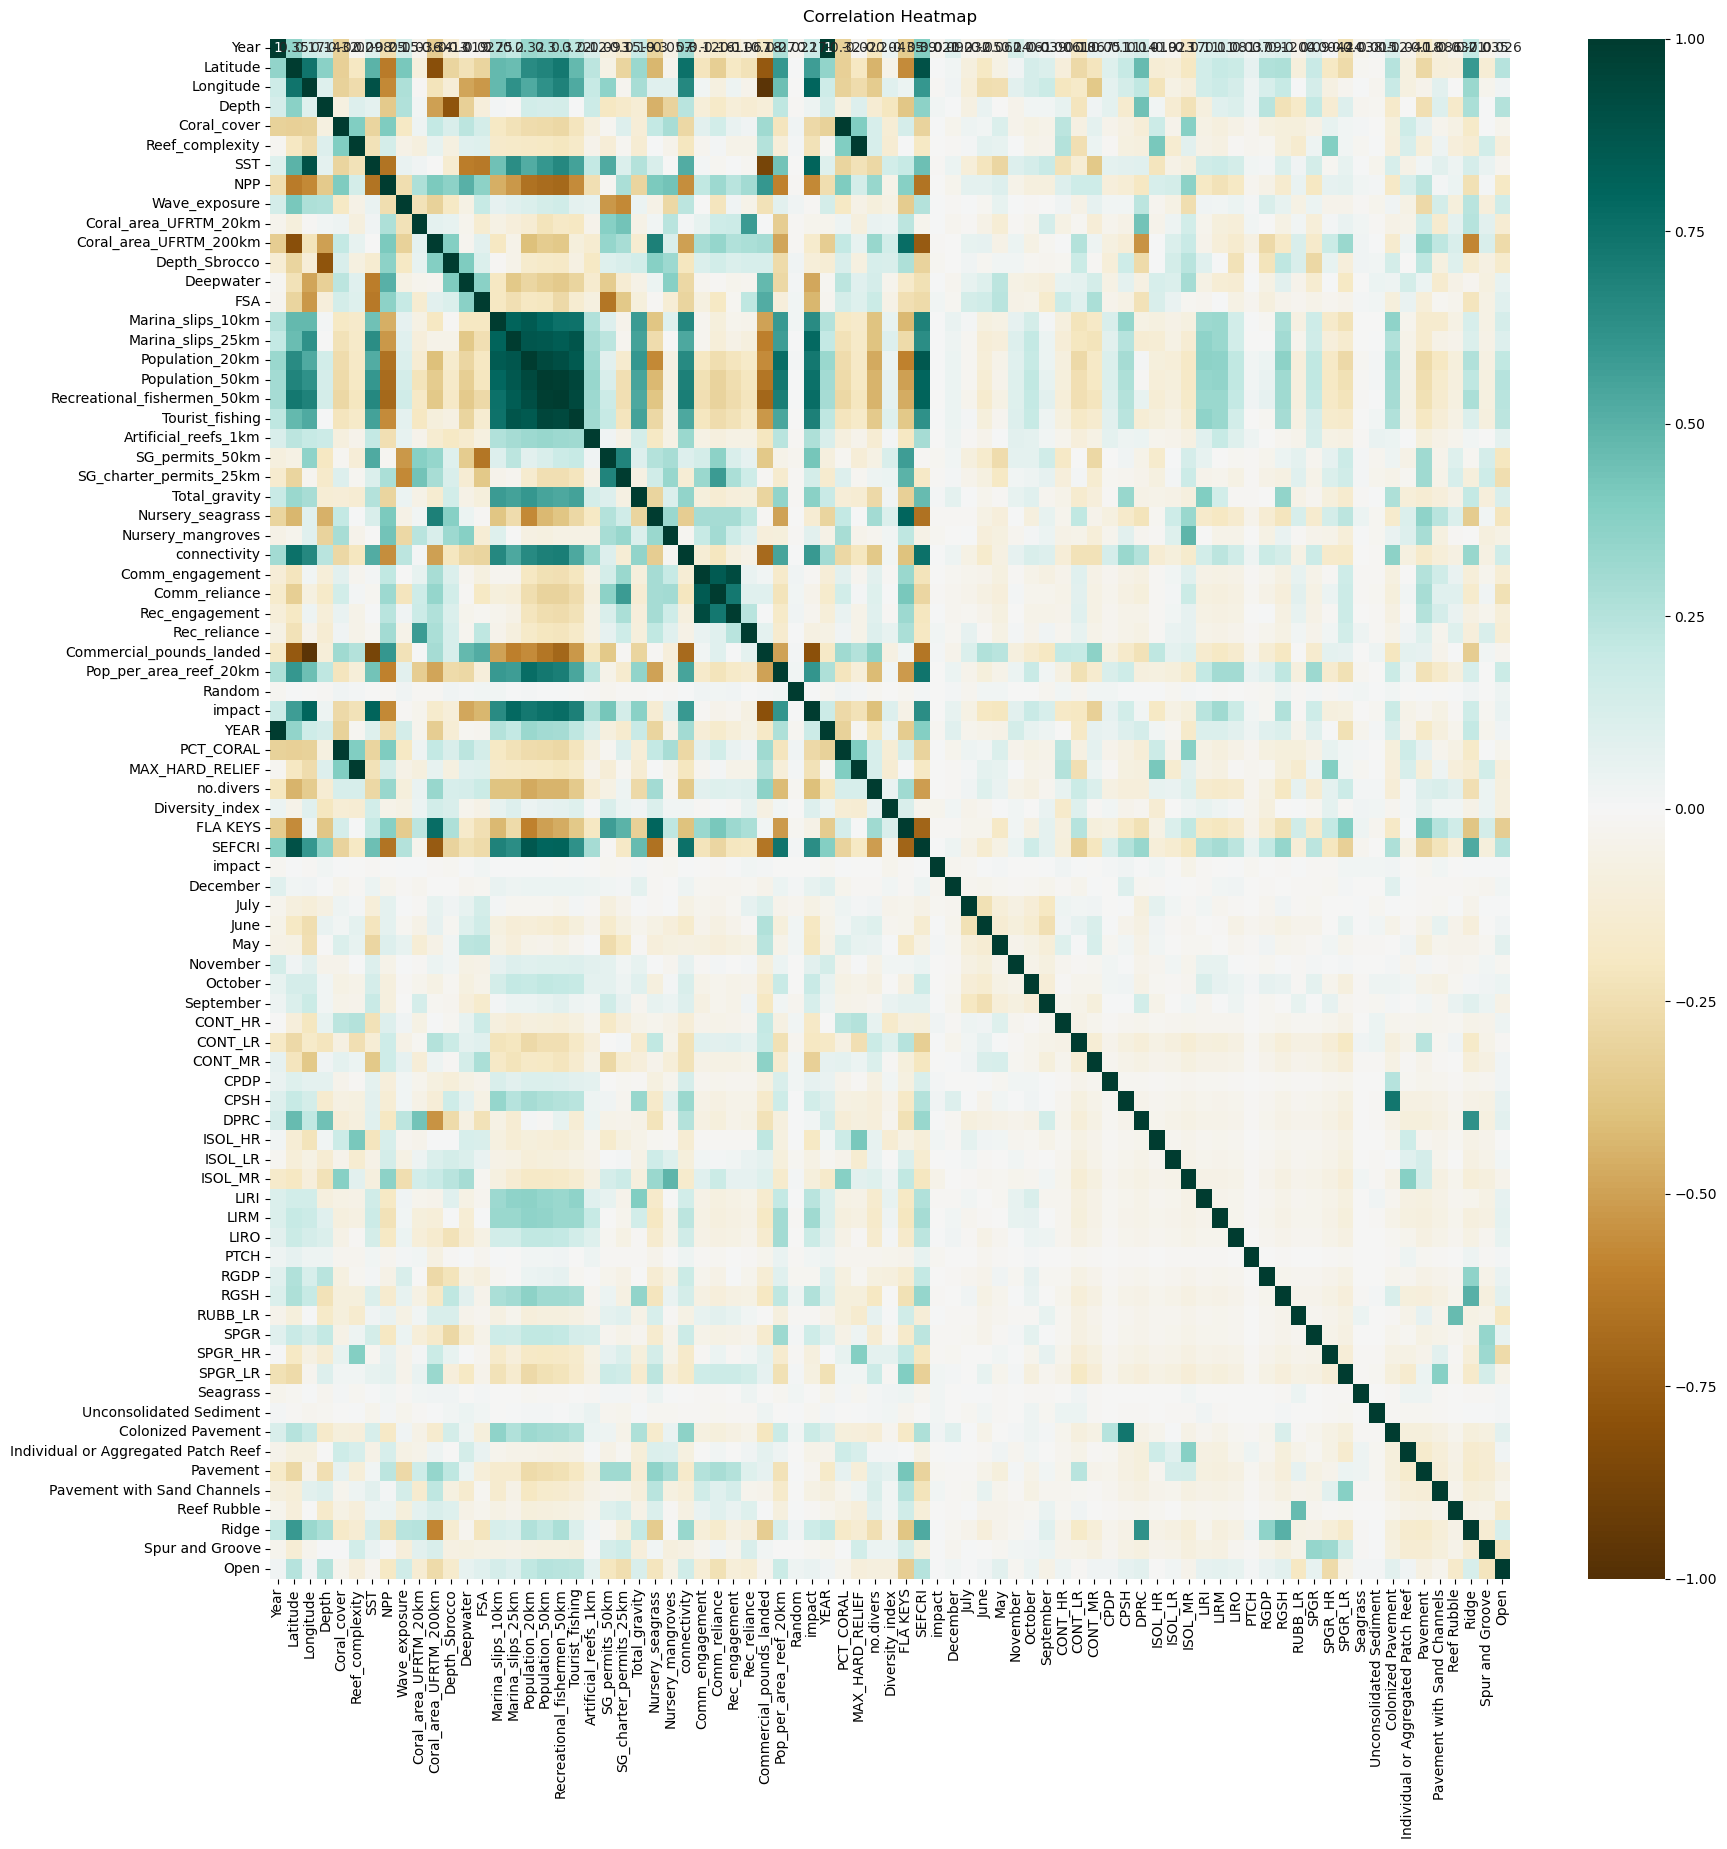

In [19]:
plt.figure(figsize=(20, 20))
#Store heatmap object in a variable to easily access it when you want to include more features (such as title).
#Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df1.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')

#Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12); plt.savefig('heatmap.png', dpi=300, bbox_inches='tight')

### Outlier treatment before building the first machine learning model

In [20]:
percentile_value = df1["Diversity_index"].quantile(0.99)
print(percentile_value)

0.9393843081


In [21]:
df2=df1[df1["Diversity_index"] < percentile_value]
df2.head()

,Year,Latitude,Longitude,Depth,Coral_cover,Reef_complexity,SST,NPP,Wave_exposure,Coral_area_UFRTM_20km,...,Seagrass,Unconsolidated Sediment,Colonized Pavement,Individual or Aggregated Patch Reef,Pavement,Pavement with Sand Channels,Reef Rubble,Ridge,Spur and Groove,Open
0,2005,24.446433,-81.962900,9.800000,2.000000,0.550322,23.595392,550.865051,6.992729,88333,...,0,0,0,0,0,0,0,0,0,1
1,2005,24.461130,-81.840099,8.821212,6.181818,1.886364,23.578271,577.431946,6.950751,91742,...,0,0,0,0,0,0,0,0,1,1
2,2005,24.467250,-81.832367,17.399239,7.506345,0.749873,23.551355,595.320252,6.950181,94607,...,0,0,0,0,1,0,0,0,0,1
3,2005,24.468767,-81.822167,9.200000,10.000000,0.400000,23.556451,590.443543,6.959807,96139,...,0,0,0,0,1,0,0,0,0,1
4,2005,24.470206,-81.808148,8.558032,2.870486,0.289415,23.567590,579.874023,6.914992,98167,...,0,0,0,0,1,0,0,0,0,1


In [22]:
df2.describe()

,Year,Latitude,Longitude,Depth,Coral_cover,Reef_complexity,SST,NPP,Wave_exposure,Coral_area_UFRTM_20km,...,Seagrass,Unconsolidated Sediment,Colonized Pavement,Individual or Aggregated Patch Reef,Pavement,Pavement with Sand Channels,Reef Rubble,Ridge,Spur and Groove,Open
count,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,...,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.00000
mean,2012.875726,25.364325,-80.909452,12.055224,4.080367,1.058891,23.761984,523.253918,7.322484,76737.625663,...,0.000758,0.001768,0.057590,0.133114,0.142713,0.081334,0.023238,0.135388,0.104572,0.90149
std,3.622569,0.807997,1.049015,6.952301,5.096309,0.776477,0.551658,163.570323,0.211440,44697.144705,...,0.027521,0.042017,0.232997,0.339741,0.349824,0.273381,0.150678,0.342180,0.306040,0.29804
min,2005.000000,24.431943,-82.986818,1.300482,0.000000,0.075887,22.405206,287.664307,5.213092,12257.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2011.000000,24.633132,-81.690988,6.398024,1.738566,0.574108,23.611047,365.582459,7.294536,50597.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
50%,2013.000000,25.123400,-80.290895,10.199640,2.051746,0.830040,23.930048,533.787293,7.368210,60695.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
75%,2016.000000,26.038378,-80.092729,17.198121,4.547805,1.299708,24.200861,632.628479,7.455555,91775.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
max,2018.000000,27.189445,-79.993800,32.295441,55.000000,10.538338,24.436212,1330.589233,7.597482,280125.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


# Machine learning model building 

Linear regression is one of the most important Supervised Machine Learning Algorithms. In brief, It is a very simple model that tries to mimic the behavior of a the dataset using a straight-line. Given that we have continuous target variable it comes as the natural first choice. 

#### First Linear Regression Model

In [23]:
#split of target variable and the remaining features
x=df2.drop(["Diversity_index"],axis=1)
y=df2.Diversity_index

#assigning less training data in the initial stages to see how the model performs, we can increase the train sample later
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.33, random_state=42)

In [24]:
#model creation and fitting in the training data
model = LinearRegression()
model.fit(xtrain, ytrain)

#predicting the test data using model.predict object
pred_le= model.predict(xtest)

In [25]:
#Model evaluation using Root mean square error and R2 error
rmse = sqrt(mean_squared_error(ytest, pred_le))
rmse = round(rmse, 3)
print('The Root Mean square Error of this Model is ', rmse)
print('The R2 score of the Model is ',r2_score(ytest,pred_le))

The Root Mean square Error of this Model is  0.109
The R2 score of the Model is  0.12851335289370813


##### Interpretation of the evaluation metrics:

Root Mean Squared Error (RMSE):

The RMSE value of 0.109 indicates the average magnitude of the errors between the predicted and actual values. Since RMSE is in the same units as the target variable, it provides a direct measure of how far the model's predictions are, on average, from the true values.
However, the adequacy of this RMSE depends on the scale of the target variable. If the target values range from 0 to 1, an RMSE of 0.109 might be acceptable. But if the target values are in a smaller range, this could represent significant prediction errors.

R² Score:

The R² score of 0.128 suggests that the model explains only about 12.8% of the variance in the target variable. This relatively low R² indicates that the model does not capture most of the variability in the data, implying that it may not be a strong predictor for this particular dataset.
A low R² score often suggests that the model may be too simple (perhaps missing important features or interactions) or that the relationship between the predictors and the target variable is not well-captured by a linear approach.

##### Overall Inference:

The model's performance appears to be suboptimal based on the given metrics. While the RMSE provides a measure of the average error, the low R² score suggests that the linear model is not adequately capturing the underlying patterns in the data. This could be due to the linear model's limitations in representing complex relationships, potential omitted variables, or noise in the data. Further model refinement, such as feature engineering, exploring non-linear models, or addressing potential issues with the dataset, may be necessary to improve predictive performance.

##### Before working on feature engineering we can try out non-linear regression models and evaluate them

#### Polynomial regression model 1

In [26]:
poly = PolynomialFeatures(degree=2, include_bias=False)

degree sets the degree of our polynomial function. degree=2 means that we want to work with a 2nd degree polynomial:

y = ß0 + ß1x + ß2x2

include_bias=False should be set to False, because we’ll use PolynomialFeatures together with LinearRegression() later on.

Long story short: LinearRegression() will take care of this setting by default, so there’s no need to set include_bias to True. If it wasn’t taken care of, then include_bias=False would mean that we deliberately want the y intercept (ß0) to be equal to 0 – but we don’t want that

In [27]:
poly_x = poly.fit_transform(x)
print(poly_x)

[[ 2.00500000e+03  2.44464334e+01 -8.19628999e+01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 2.00500000e+03  2.44611303e+01 -8.18400989e+01 ...  1.00000000e+00
   1.00000000e+00  1.00000000e+00]
 [ 2.00500000e+03  2.44672500e+01 -8.18323666e+01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 ...
 [ 2.01800000e+03  2.55908327e+01 -8.00967064e+01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 2.01800000e+03  2.58381208e+01 -8.00994202e+01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]
 [ 2.01800000e+03  2.58217982e+01 -8.00911364e+01 ...  0.00000000e+00
   0.00000000e+00  1.00000000e+00]]


In [28]:
#assigning less training data in the initial stages to see how the model performs, we can increase the train sample later
xtrain_p, xtest_p, ytrain_p, ytest_p = train_test_split(poly_x, y, test_size=0.33, random_state=42)

In [29]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(xtrain_p, ytrain_p)

LinearRegression()

In [30]:
#predicting the test data using model.predict object
pred_po= poly_reg_model.predict(xtest_p)

#Model evaluation using Root mean square error and R2 error
rmse = sqrt(mean_squared_error(ytest_p, pred_po))
rmse = round(rmse, 3)
print('The Root Mean square Error of this Model is ',rmse)
print('The R2 score of the Model is ', r2_score(ytest_p,pred_po))

The Root Mean square Error of this Model is  9.835
The R2 score of the Model is  -7118.185457191937


##### Overall Inference:
The model's performance is highly inadequate and indicates that something is seriously wrong. The extremely high RMSE and severely negative R² score suggest that the model's predictions are not just inaccurate—they are dramatically off from the actual values.
This could be due to several factors:
- Severe Model Misspecification: The linear model might be entirely unsuitable for the data, possibly because of strong non-linear relationships that it cannot capture.
- Data Issues: There may be issues with the data itself, such as incorrect feature-target pairings, outliers, or incorrect data preprocessing steps (e.g., scaling issues).
- Feature Engineering: The features being used might not be relevant or sufficient to predict the target variable, leading to poor model performance.

##### Given these results, a thorough investigation into the data, feature selection, and model choice is necessary.

##### Before moving further with feature engineering we can apply simple feature selection techniques, and rebuild the model and see how the evaluation metrics are changing

After analyzing we can suspect some sort of multicollinearity and hence we can try out the Variance inflation factor to evaluate the features that we want to select for our models. 
multicollinearity exists when two or more of the independent variables demonstrate a linear relationship between them. With multicollinearity, the regression coefficients are still consistent but are no longer reliable since the standard errors are inflated. It means that the model’s predictive power is not reduced, but the coefficients may not be statistically significant with a Type II error.

##### Variance Inflation Factor

In [31]:
def calculate_vif(df):
    """
    Calculate the Variance Inflation Factor (VIF) for each feature in the DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the features.

    Returns:
    pandas.DataFrame: DataFrame containing features and their corresponding VIF values.
    """
    # Add a constant column to the DataFrame (required for calculating VIF)
    df_with_constant = add_constant(df)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i) 
                       for i in range(df_with_constant.shape[1])]

    # Remove the VIF of the constant column
    vif_data = vif_data[vif_data["Feature"] != "const"]

    return vif_data.reset_index(drop=True)

In [32]:
calculate_vif(x)

,Feature,VIF
0,Year,inf
1,Latitude,8.266575e+02
2,Longitude,6.584050e+02
3,Depth,5.344917e+00
4,Coral_cover,inf
5,Reef_complexity,inf
6,SST,6.612777e+01
7,NPP,7.727874e+00
8,Wave_exposure,3.564870e+00
9,Coral_area_UFRTM_20km,8.905564e+00


Interpreting VIF Values:
VIF < 5: The variable has low multicollinearity (no significant issue).
VIF between 5 and 10: The variable has moderate multicollinearity (requires further investigation).
VIF > 10: The variable has high multicollinearity (serious issue, consider mitigation techni)que

And we also need to consider that VIF < 5 for categorical data (even the hot encoded one) does not explain the multicollinearitys).

In [33]:
#based on the above mentioned interpretation we can select the following features alone for the new model
df4=(df2[["Depth","impact","Nursery_seagrass","SG_permits_50km","Depth_Sbrocco","Diversity_index"]])

In [34]:
df4.head()

,Depth,impact,impact,Nursery_seagrass,SG_permits_50km,Depth_Sbrocco,Diversity_index
0,9.800000,0.20500,0,6483631.0,54,-10.0,0.877755
1,8.821212,0.38200,1,11501368.0,70,-6.0,0.912085
2,17.399239,0.38798,0,12102752.0,70,-7.0,0.882112
3,9.200000,0.38798,1,11003196.0,70,-7.0,0.806049
4,8.558032,0.38798,1,9313051.0,70,-14.0,0.829156


#### Second linear regression model

In [35]:
#split of variables
x2=df4.drop(["Diversity_index"],axis=1)
y2=df4.Diversity_index

#assigning less training data in the initial stages to see how the model performs, we can increase the train sample later
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x2, y2, test_size=0.33, random_state=42)

In [36]:
model2 = LinearRegression()
model2.fit(xtrain2, ytrain2)

LinearRegression()

In [37]:
pred_le2= model2.predict(xtest2)

rmse2 = sqrt(mean_squared_error(ytest2, pred_le2))
rmse2 = round(rmse2, 3)
print('The Root Mean square Error of this Model is ',rmse2)
print('The R2 score of the Model is ',r2_score(ytest2,pred_le2))

The Root Mean square Error of this Model is  0.114
The R2 score of the Model is  0.040885914701286996


##### Interpretation of the model

The results have become worse compared to the previous linear regression model with very similar insights. 
All insights from the previous model apply here too

##### We can try the polynomial regression for this new smaller dataset

#### Polynomial regerssion model 2

In [38]:
poly_x2 = poly.fit_transform(x2)

In [39]:
poly_x2

array([[ 9.80000000e+00,  2.05000000e-01,  0.00000000e+00, ...,
         2.91600000e+03, -5.40000000e+02,  1.00000000e+02],
       [ 8.82121212e+00,  3.82000000e-01,  1.00000000e+00, ...,
         4.90000000e+03, -4.20000000e+02,  3.60000000e+01],
       [ 1.73992386e+01,  3.87980422e-01,  0.00000000e+00, ...,
         4.90000000e+03, -4.90000000e+02,  4.90000000e+01],
       ...,
       [ 2.45547826e+00,  7.05000000e-01,  0.00000000e+00, ...,
         2.30400000e+03, -8.16000000e+02,  2.89000000e+02],
       [ 8.14507042e+00,  7.40000000e-01,  1.00000000e+00, ...,
         2.80900000e+03, -3.18000000e+02,  3.60000000e+01],
       [ 1.43445883e+01,  7.40000000e-01,  1.00000000e+00, ...,
         2.80900000e+03, -6.36000000e+02,  1.44000000e+02]])

In [40]:
poly_reg_model2 = LinearRegression()

In [41]:
#assigning less training data in the initial stages to see how the model performs, we can increase the train sample later
xtrain_p2, xtest_p2, ytrain_p2, ytest_p2 = train_test_split(poly_x2, y2, test_size=0.33, random_state=42)

In [42]:
poly_reg_model2.fit(xtrain_p2, ytrain_p2)

LinearRegression()

In [43]:
#predicting the test data using model.predict object
pred_po2= poly_reg_model2.predict(xtest_p2)

#Model evaluation using Root mean square error and R2 error
rmse = sqrt(mean_squared_error(ytest_p2, pred_po2))
rmse = round(rmse, 3)
print(rmse)
r2_score(ytest_p2,pred_po2)

0.113


0.05955258708155742

##### No major improvement in terms of the evaluation metrics

## We need more data :)

#### Since the species data does not have data related to the count of each  species that relates to the diversity index we need to now use the detailed data set named SpecAbund and repeat the above process to see how the evaluation metrics are improving

In [44]:
#data import of SpecAbund Data
SpecAbund_df = pd.read_excel("C://Users/susmi/Documents/ML/Project 2/Data/SpecAbund.xlsx")

In [45]:
SpecAbund_df.head(10)

,site,model,Year,Month,Latitude,Longitude,Depth,Region,Coral_cover,Reef_complexity,...,Sphoeroides.spengleri,Stegastes.adustus,Stegastes.diencaeus,Stegastes.leucostictus,Stegastes.partitus,Stegastes.planifrons,Stegastes.variabilis,Thalassoma.bifasciatum,Urobatis.jamaicensis,Xyrichtys.splendens
0,4733520_128U,biomass,2005,August,24.446433,-81.962900,9.800000,FLA KEYS,2.000000,0.550322,...,0.0,0.0,0.0,0.0,72.0,0.0,8.0,228.0,0.0,0.0
1,4966028_487U,impact,2005,June,24.461130,-81.840099,8.821212,FLA KEYS,6.181818,1.886364,...,0.0,0.0,0.0,2.0,68.0,14.0,10.0,146.0,0.0,0.0
2,4981032_102U,biomass,2005,July,24.467250,-81.832367,17.399239,FLA KEYS,7.506345,0.749873,...,0.0,0.0,0.0,4.0,240.0,40.0,0.0,84.0,0.0,0.0
3,4999782_141U,impact,2005,August,24.468767,-81.822167,9.200000,FLA KEYS,10.000000,0.400000,...,0.0,0.0,0.0,0.0,20.0,0.0,0.0,112.0,4.0,0.0
4,5026033_475U,impact,2005,June,24.470206,-81.808148,8.558032,FLA KEYS,2.870486,0.289415,...,0.0,0.0,0.0,0.0,54.0,0.0,0.0,266.0,0.0,0.0
5,5067281_105U,biomass,2005,July,24.466283,-81.786533,26.504821,FLA KEYS,17.620519,1.200000,...,0.0,0.0,0.0,4.0,136.0,24.0,12.0,24.0,0.0,0.0
6,5157285_104U,impact,2005,July,24.474067,-81.739067,8.696966,FLA KEYS,25.018963,1.149431,...,0.0,0.0,0.0,0.0,52.0,28.0,0.0,88.0,0.0,0.0
7,5168534_472U,biomass,2005,June,24.471833,-81.733867,20.300000,FLA KEYS,6.000000,1.300000,...,0.0,0.0,0.0,0.0,5.0,0.0,5.0,4.0,0.0,0.0
8,5187287_495U,biomass,2005,June,24.477337,-81.722680,20.463554,FLA KEYS,9.817768,1.700000,...,0.0,0.0,0.0,2.0,40.0,0.0,12.0,90.0,0.0,0.0
9,5194788_112U,biomass,2005,July,24.479050,-81.718833,9.500000,FLA KEYS,2.493606,0.849361,...,0.0,0.0,0.0,4.0,88.0,0.0,24.0,208.0,0.0,0.0


#### The SpecAbund dataset does not have the diversity index (the target variable), hence we will be appending it from the species dataset

In [46]:
SpecAbund_df.head()

,site,model,Year,Month,Latitude,Longitude,Depth,Region,Coral_cover,Reef_complexity,...,Sphoeroides.spengleri,Stegastes.adustus,Stegastes.diencaeus,Stegastes.leucostictus,Stegastes.partitus,Stegastes.planifrons,Stegastes.variabilis,Thalassoma.bifasciatum,Urobatis.jamaicensis,Xyrichtys.splendens
0,4733520_128U,biomass,2005,August,24.446433,-81.962900,9.800000,FLA KEYS,2.000000,0.550322,...,0.0,0.0,0.0,0.0,72.0,0.0,8.0,228.0,0.0,0.0
1,4966028_487U,impact,2005,June,24.461130,-81.840099,8.821212,FLA KEYS,6.181818,1.886364,...,0.0,0.0,0.0,2.0,68.0,14.0,10.0,146.0,0.0,0.0
2,4981032_102U,biomass,2005,July,24.467250,-81.832367,17.399239,FLA KEYS,7.506345,0.749873,...,0.0,0.0,0.0,4.0,240.0,40.0,0.0,84.0,0.0,0.0
3,4999782_141U,impact,2005,August,24.468767,-81.822167,9.200000,FLA KEYS,10.000000,0.400000,...,0.0,0.0,0.0,0.0,20.0,0.0,0.0,112.0,4.0,0.0
4,5026033_475U,impact,2005,June,24.470206,-81.808148,8.558032,FLA KEYS,2.870486,0.289415,...,0.0,0.0,0.0,0.0,54.0,0.0,0.0,266.0,0.0,0.0


In [47]:
merged_df = SpecAbund_df.merge(species_df[['site', 'Diversity_index']], on='site', how='left')

In [48]:
SpecAbund_df['Diversity_index'] = merged_df['Diversity_index']

In [49]:
SpecAbund_df.head()

,site,model,Year,Month,Latitude,Longitude,Depth,Region,Coral_cover,Reef_complexity,...,Stegastes.adustus,Stegastes.diencaeus,Stegastes.leucostictus,Stegastes.partitus,Stegastes.planifrons,Stegastes.variabilis,Thalassoma.bifasciatum,Urobatis.jamaicensis,Xyrichtys.splendens,Diversity_index
0,4733520_128U,biomass,2005,August,24.446433,-81.962900,9.800000,FLA KEYS,2.000000,0.550322,...,0.0,0.0,0.0,72.0,0.0,8.0,228.0,0.0,0.0,0.877755
1,4966028_487U,impact,2005,June,24.461130,-81.840099,8.821212,FLA KEYS,6.181818,1.886364,...,0.0,0.0,2.0,68.0,14.0,10.0,146.0,0.0,0.0,0.912085
2,4981032_102U,biomass,2005,July,24.467250,-81.832367,17.399239,FLA KEYS,7.506345,0.749873,...,0.0,0.0,4.0,240.0,40.0,0.0,84.0,0.0,0.0,0.882112
3,4999782_141U,impact,2005,August,24.468767,-81.822167,9.200000,FLA KEYS,10.000000,0.400000,...,0.0,0.0,0.0,20.0,0.0,0.0,112.0,4.0,0.0,0.806049
4,5026033_475U,impact,2005,June,24.470206,-81.808148,8.558032,FLA KEYS,2.870486,0.289415,...,0.0,0.0,0.0,54.0,0.0,0.0,266.0,0.0,0.0,0.829156


In [50]:
SpecAbund_df.nunique()

site                            3999
model                              2
Year                              12
Month                              8
Latitude                        3984
Longitude                       3969
Depth                           3293
Region                             3
Coral_cover                     2414
Reef_complexity                 2814
SST                             3428
NPP                             3660
Wave_exposure                   3673
Habitat_type_classLV0              3
Habitat_type_classLV2              8
Coral_area_UFRTM_20km           3253
Coral_area_UFRTM_200km          3608
Depth_Sbrocco                     64
Deepwater                        787
FSA                             3065
Marina_slips_10km                543
Marina_slips_25km                508
Marine_reserve                     2
Population_20km                 1051
Population_50km                 1039
Recreational_fishermen_50km     1009
Tourist_fishing                 1800
A

In [51]:
#again dropping the columsn with only one unquie value
SpecAbund_df1=SpecAbund_df.drop(columns=['FKNMS','DryTortugas','BNP','CoralECA','Total_gravity_intercept','Keys_Divisions'])

In [52]:
print(SpecAbund_df1.dtypes)

site                             object
model                            object
Year                              int64
Month                            object
Latitude                        float64
Longitude                       float64
Depth                           float64
Region                           object
Coral_cover                     float64
Reef_complexity                 float64
SST                             float64
NPP                             float64
Wave_exposure                   float64
Habitat_type_classLV0            object
Habitat_type_classLV2            object
Coral_area_UFRTM_20km             int64
Coral_area_UFRTM_200km            int64
Depth_Sbrocco                   float64
Deepwater                       float64
FSA                             float64
Marina_slips_10km                 int64
Marina_slips_25km                 int64
Marine_reserve                   object
Population_20km                   int64
Population_50km                   int64


In [53]:
SpecAbund_df1.describe()

,Year,Latitude,Longitude,Depth,Coral_cover,Reef_complexity,SST,NPP,Wave_exposure,Coral_area_UFRTM_20km,...,Stegastes.adustus,Stegastes.diencaeus,Stegastes.leucostictus,Stegastes.partitus,Stegastes.planifrons,Stegastes.variabilis,Thalassoma.bifasciatum,Urobatis.jamaicensis,Xyrichtys.splendens,Diversity_index
count,3999.000000,3999.000000,3999.000000,3999.000000,3292.000000,3292.000000,3999.000000,3999.000000,3999.000000,3999.000000,...,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000,3999.000000
mean,2012.886222,25.361813,-80.912910,12.031226,4.549820,1.100154,23.760696,523.320811,7.322459,76727.255314,...,1.626031,0.439443,2.255981,121.293533,2.959615,13.253152,107.389044,0.159539,1.801902,0.831469
std,3.629448,0.806724,1.051129,6.942690,5.522744,0.851008,0.552442,163.404174,0.211270,44693.794158,...,6.480834,2.349285,5.578310,186.382011,9.660449,25.365548,120.184935,0.672434,8.344495,0.114777
min,2005.000000,24.431943,-82.986818,1.300482,0.000000,0.075887,22.405206,287.664307,5.213092,12257.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,24.632586,-81.695419,6.351316,1.500000,0.500000,23.608484,365.925385,7.294437,50594.000000,...,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,25.000000,0.000000,0.000000,0.811582
50%,2013.000000,25.123213,-80.292226,10.171806,2.758143,0.900596,23.929285,533.677063,7.368210,60682.000000,...,0.000000,0.000000,0.000000,60.000000,0.000000,3.000000,67.000000,0.000000,0.000000,0.867035
75%,2016.000000,26.034196,-80.092946,17.148568,5.283544,1.448243,24.200861,632.628479,7.455595,91516.000000,...,0.000000,0.000000,2.000000,150.000000,1.000000,13.000000,152.000000,0.000000,0.000000,0.900148
max,2018.000000,27.189445,-79.993800,32.295441,55.000000,10.538338,24.436212,1330.589233,7.597482,280125.000000,...,128.000000,42.000000,94.000000,4480.000000,132.000000,248.000000,1240.000000,10.000000,174.000000,0.956324


In [54]:
SpecAbund_df1.isna().sum()

site                               0
model                              0
Year                               0
Month                              0
Latitude                           0
Longitude                          0
Depth                              0
Region                             0
Coral_cover                      707
Reef_complexity                  707
SST                                0
NPP                                0
Wave_exposure                      0
Habitat_type_classLV0              0
Habitat_type_classLV2              0
Coral_area_UFRTM_20km              0
Coral_area_UFRTM_200km             0
Depth_Sbrocco                      0
Deepwater                          0
FSA                                0
Marina_slips_10km                  0
Marina_slips_25km                  0
Marine_reserve                     0
Population_20km                    0
Population_50km                    0
Recreational_fishermen_50km        0
Tourist_fishing                    0
A

In [55]:
df1=SpecAbund_df1

In [56]:
#NULL VALUE TREATMENT
df1.loc[df1["Commercial_pounds_landed"].isna(),"Commercial_pounds_landed"] = df1.Commercial_pounds_landed.mean()
for nod in [2, 4, 6]:
    # Calculate mean Coral_cover for the given no.divers and Habitat_type_classLV0
    mean_coral_cover = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "Coral_cover"
    ].mean()
    mean_reef_complexity = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "Reef_complexity"
    ].mean()
    mean_connectivity = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "connectivity"
    ].mean()
    mean_total_gravity = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "Total_gravity"
    ].mean()
    mean_comm_engagement = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "Comm_engagement"
    ].mean()
    mean_comm_reliance = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "Comm_reliance"
    ].mean()
    mean_rec_engagement = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "Rec_engagement"
    ].mean()
    mean_rec_reliance = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "Rec_reliance"
    ].mean()
    mean_impact_sefcri = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "SEFCRI"),
        "impact"
    ].mean()
    mean_impact_flakeys = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "FLA KEYS"),
        "impact"
    ].mean()
    mean_impact_drytort = df1.loc[
        (df1["no.divers"] == nod) & ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & (df1["Region"] == "DRY TORT"),
        "impact"
    ].mean()
    mean_pct_coral = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "PCT_CORAL"
    ].mean()
    mean_max_hard_relief = df1.loc[
        (df1["no.divers"] == nod) & (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & (df1["Region"] == "SEFCRI"),
        "MAX_HARD_RELIEF"
    ].mean()
    
    # Fill missing Coral_cover values
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["Coral_cover"].isna(),
        "Coral_cover"
    ] = mean_coral_cover
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["Reef_complexity"].isna(),
        "Reef_complexity"
    ] = mean_reef_complexity
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["connectivity"].isna(),
        "connectivity"
    ] = mean_connectivity
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["Total_gravity"].isna(),
        "Total_gravity"
    ] = mean_total_gravity
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
        df1["Comm_engagement"].isna(),
        "Comm_engagement"
    ] = mean_comm_engagement
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
        df1["Comm_reliance"].isna(),
        "Comm_reliance"
    ] = mean_comm_reliance
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
        df1["Rec_engagement"].isna(),
        "Rec_engagement"
    ] = mean_rec_engagement
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & df1["Rec_reliance"].isna(),"Rec_reliance"
    ] = mean_rec_reliance
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
		(df1["Region"] == "SEFCRI") & 
        df1["impact"].isna(),
        "impact"
    ] = mean_impact_sefcri
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
		(df1["Region"] == "FLA KEYS") & 
        df1["impact"].isna(),
        "impact"
    ] = mean_impact_flakeys
    df1.loc[
        (df1["no.divers"] == nod) & 
        ((df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") | (df1["Habitat_type_classLV0"] == "Seagrass")) & 
		(df1["Region"] == "DRY TORT") & 
        df1["impact"].isna(),
        "impact"
    ] = mean_impact_drytort
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["PCT_CORAL"].isna(),
        "PCT_CORAL"
    ] = mean_pct_coral
    df1.loc[
        (df1["no.divers"] == nod) & 
        (df1["Habitat_type_classLV0"] == "Coral Reef and Hardbottom") & 
        df1["MAX_HARD_RELIEF"].isna(),
        "MAX_HARD_RELIEF"
    ] = mean_max_hard_relief

In [57]:
df1.isna().sum()

site                            0
model                           0
Year                            0
Month                           0
Latitude                        0
Longitude                       0
Depth                           0
Region                          0
Coral_cover                     0
Reef_complexity                 0
SST                             0
NPP                             0
Wave_exposure                   0
Habitat_type_classLV0           0
Habitat_type_classLV2           0
Coral_area_UFRTM_20km           0
Coral_area_UFRTM_200km          0
Depth_Sbrocco                   0
Deepwater                       0
FSA                             0
Marina_slips_10km               0
Marina_slips_25km               0
Marine_reserve                  0
Population_20km                 0
Population_50km                 0
Recreational_fishermen_50km     0
Tourist_fishing                 0
Artificial_reefs_1km            0
SG_permits_50km                 0
SG_charter_per

In [58]:
df1 = df1.drop(columns=['site','REGION'])

In [59]:
# get_dummies tranforms categorical data to numbers

region_dummies = pd.get_dummies(df1.Region, drop_first=True, dtype=int)
# Concatenate the dummy variables with the original DataFrame
df1 = pd.concat([df1, region_dummies], axis=1)
# Drop the original 'Region' column if desired
df1.drop(columns=["Region"], inplace=True)

model_dummies = pd.get_dummies(df1.model, drop_first=True, dtype=int)
df1 = pd.concat([df1, model_dummies], axis=1)
df1.drop(columns=["model"], inplace=True)

Month_dummies = pd.get_dummies(df1.Month, drop_first=True, dtype=int)
df1 = pd.concat([df1, Month_dummies], axis=1)
df1.drop(columns=["Month"], inplace=True)

HABITAT_CD_dummies = pd.get_dummies(df1.HABITAT_CD, drop_first=True, dtype=int)
df1 = pd.concat([df1, HABITAT_CD_dummies], axis=1)
df1.drop(columns=["HABITAT_CD"], inplace=True)

Habitat_type_classLV0_dummies = pd.get_dummies(df1.Habitat_type_classLV0, drop_first=True, dtype=int)
df1 = pd.concat([df1, Habitat_type_classLV0_dummies], axis=1)
df1.drop(columns=["Habitat_type_classLV0"], inplace=True)

Habitat_type_classLV2_dummies = pd.get_dummies(df1.Habitat_type_classLV2, drop_first=True, dtype=int)
df1 = pd.concat([df1, Habitat_type_classLV2_dummies], axis=1)
df1.drop(columns=["Habitat_type_classLV2"], inplace=True)

Marine_reserve_dummies = pd.get_dummies(df1.Marine_reserve, drop_first=True, dtype=int)
df1 = pd.concat([df1, Marine_reserve_dummies], axis=1)
df1.drop(columns=["Marine_reserve"], inplace=True)

In [60]:
print(df1.dtypes)

Year                                     int64
Latitude                               float64
Longitude                              float64
Depth                                  float64
Coral_cover                            float64
Reef_complexity                        float64
SST                                    float64
NPP                                    float64
Wave_exposure                          float64
Coral_area_UFRTM_20km                    int64
Coral_area_UFRTM_200km                   int64
Depth_Sbrocco                          float64
Deepwater                              float64
FSA                                    float64
Marina_slips_10km                        int64
Marina_slips_25km                        int64
Population_20km                          int64
Population_50km                          int64
Recreational_fishermen_50km              int64
Tourist_fishing                        float64
Artificial_reefs_1km                     int64
SG_permits_50

##### Removal of outliers

In [61]:
percentile_value = df1["Diversity_index"].quantile(0.99)
print(percentile_value)

0.9393843081


In [62]:
df2=df1[df1["Diversity_index"] < percentile_value]
df2.head()

,Year,Latitude,Longitude,Depth,Coral_cover,Reef_complexity,SST,NPP,Wave_exposure,Coral_area_UFRTM_20km,...,Seagrass,Unconsolidated Sediment,Colonized Pavement,Individual or Aggregated Patch Reef,Pavement,Pavement with Sand Channels,Reef Rubble,Ridge,Spur and Groove,Open
0,2005,24.446433,-81.962900,9.800000,2.000000,0.550322,23.595392,550.865051,6.992729,88333,...,0,0,0,0,0,0,0,0,0,1
1,2005,24.461130,-81.840099,8.821212,6.181818,1.886364,23.578271,577.431946,6.950751,91742,...,0,0,0,0,0,0,0,0,1,1
2,2005,24.467250,-81.832367,17.399239,7.506345,0.749873,23.551355,595.320252,6.950181,94607,...,0,0,0,0,1,0,0,0,0,1
3,2005,24.468767,-81.822167,9.200000,10.000000,0.400000,23.556451,590.443543,6.959807,96139,...,0,0,0,0,1,0,0,0,0,1
4,2005,24.470206,-81.808148,8.558032,2.870486,0.289415,23.567590,579.874023,6.914992,98167,...,0,0,0,0,1,0,0,0,0,1


In [63]:
df2.describe()

,Year,Latitude,Longitude,Depth,Coral_cover,Reef_complexity,SST,NPP,Wave_exposure,Coral_area_UFRTM_20km,...,Seagrass,Unconsolidated Sediment,Colonized Pavement,Individual or Aggregated Patch Reef,Pavement,Pavement with Sand Channels,Reef Rubble,Ridge,Spur and Groove,Open
count,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,...,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.00000
mean,2012.875726,25.364325,-80.909452,12.055224,4.080367,1.058891,23.761984,523.253918,7.322484,76737.625663,...,0.000758,0.001768,0.057590,0.133114,0.142713,0.081334,0.023238,0.135388,0.104572,0.90149
std,3.622569,0.807997,1.049015,6.952301,5.096309,0.776477,0.551658,163.570323,0.211440,44697.144705,...,0.027521,0.042017,0.232997,0.339741,0.349824,0.273381,0.150678,0.342180,0.306040,0.29804
min,2005.000000,24.431943,-82.986818,1.300482,0.000000,0.075887,22.405206,287.664307,5.213092,12257.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2011.000000,24.633132,-81.690988,6.398024,1.738566,0.574108,23.611047,365.582459,7.294536,50597.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
50%,2013.000000,25.123400,-80.290895,10.199640,2.051746,0.830040,23.930048,533.787293,7.368210,60695.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
75%,2016.000000,26.038378,-80.092729,17.198121,4.547805,1.299708,24.200861,632.628479,7.455555,91775.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000
max,2018.000000,27.189445,-79.993800,32.295441,55.000000,10.538338,24.436212,1330.589233,7.597482,280125.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


### Machine learning model building - Phase 2

#### Linear regression

In [64]:
x=df2.drop(["Diversity_index"],axis=1)
y=df2.Diversity_index

#train test split
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.33, random_state=42)

In [65]:
#Model definition
model3 = LinearRegression()
#model fit
model3.fit(xtrain, ytrain)
#model Eva
pred_le3= model3.predict(xtest)

rmse3 = sqrt(mean_squared_error(ytest, pred_le3))
rmse3 = round(rmse3, 3)
print('The Root Mean square Error of the 3rd LR Model is ',rmse3)
print('The R2 score of the 3rd LR Model is ',r2_score(ytest,pred_le3))

The Root Mean square Error of the 3rd LR Model is  0.091
The R2 score of the 3rd LR Model is  0.3871468654681969


#### Inference for the Linear Regression Model:

The linear regression model has shown improvement after adding new data. The Root Mean Squared Error (RMSE) has decreased from 0.109 to 0.091, and the R² score has increased from 0.128 to 0.38714.

##### Interpretation:
##### Root Mean Squared Error (RMSE):
The decrease in RMSE from 0.109 to 0.091 indicates that the average magnitude of prediction errors has been reduced. This improvement suggests that the model is now making more accurate predictions, with the predicted values being closer to the actual target values.
##### R² Score:
The increase in the R² score from 0.128 to 0.38714 is a significant improvement. The R² score represents the proportion of variance in the target variable that is explained by the model. With an R² of 0.38714, the model now explains approximately 38.7% of the variance in the target variable, compared to just 12.8% before. This suggests that the model’s ability to capture the relationship between the features and the target variable has improved considerably.

#### Overall Inference:
The improvements in both RMSE and R² indicate that adding new data has positively impacted the model’s performance. The reduction in RMSE shows that the predictions have become more accurate, while the increase in R² suggests that the model now captures more of the underlying variance in the target variable.
These improvements could be due to several factors, such as the new data providing additional information that better explains the target variable, reducing noise in the model, or increasing the model’s ability to generalize.
The model's enhanced performance demonstrates the value of incorporating additional data, especially when the initial model was struggling to capture the underlying patterns.

#### Phase 2 feature Selection for the new improved dataset

In [66]:
#analyzing the correlation of variables
new_corr=df2.corr()

In [67]:
new_corr.Diversity_index

Year                                   0.037427
Latitude                              -0.046399
Longitude                              0.091507
Depth                                 -0.206076
Coral_cover                           -0.135928
Reef_complexity                       -0.142817
SST                                    0.155984
NPP                                   -0.048919
Wave_exposure                         -0.068274
Coral_area_UFRTM_20km                  0.044871
Coral_area_UFRTM_200km                 0.148739
Depth_Sbrocco                          0.118569
Deepwater                             -0.043881
FSA                                   -0.062364
Marina_slips_10km                      0.060402
Marina_slips_25km                      0.108670
Population_20km                        0.047746
Population_50km                        0.067763
Recreational_fishermen_50km            0.072291
Tourist_fishing                        0.096713
Artificial_reefs_1km                   0

##### Similar to phase 1 we can use Variance Inflation factor analysis

In [68]:
def calculate_vif(df):
    """
    Calculate the Variance Inflation Factor (VIF) for each feature in the DataFrame.

    Parameters:
    df (pandas.DataFrame): DataFrame containing the features.

    Returns:
    pandas.DataFrame: DataFrame containing features and their corresponding VIF values.
    """
    # Add a constant column to the DataFrame (required for calculating VIF)
    df_with_constant = add_constant(df)

    # Calculate VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df_with_constant.columns
    vif_data["VIF"] = [variance_inflation_factor(df_with_constant.values, i) 
                       for i in range(df_with_constant.shape[1])]

    # Remove the VIF of the constant column
    vif_data = vif_data[vif_data["Feature"] != "const"]

    return vif_data.reset_index(drop=True)

In [69]:
calculate_vif(x)

,Feature,VIF
0,Year,inf
1,Latitude,8.815659e+02
2,Longitude,7.065506e+02
3,Depth,8.379596e+00
4,Coral_cover,inf
5,Reef_complexity,inf
6,SST,7.099157e+01
7,NPP,8.174723e+00
8,Wave_exposure,3.807322e+00
9,Coral_area_UFRTM_20km,9.499280e+00


In [70]:
calculate_vifx_df = calculate_vif(x)

In [71]:
calculate_vifx_df1=calculate_vifx_df.loc[calculate_vifx_df["VIF"]<5]["Feature"]

In [72]:
print(calculate_vifx_df1)

8                            Wave_exposure
11                           Depth_Sbrocco
12                               Deepwater
20                    Artificial_reefs_1km
23                           Total_gravity
25                       Nursery_mangroves
30                            Rec_reliance
33                                  Random
38                               no.divers
39                     Abudefduf.saxatilis
40                     Acanthurus.bahianus
41                    Acanthurus.chirurgus
42                    Acanthurus.coeruleus
43              Acanthostracion.polygonius
44            Acanthostracion.quadricornis
45                          Acanthurus.sp.
46                       Aluterus.scriptus
47                Anisotremus.surinamensis
48                  Anisotremus.virginicus
49                    Aulostomus.maculatus
50                      Balistes.capriscus
51                          Bodianus.rufus
52                         Calamus.calamus
53         

In [73]:
calculate_vifx_df1_list = calculate_vifx_df1.values.tolist()

In [74]:
print(calculate_vifx_df1_list)

['Wave_exposure', 'Depth_Sbrocco', 'Deepwater', 'Artificial_reefs_1km', 'Total_gravity', 'Nursery_mangroves', 'Rec_reliance', 'Random', 'no.divers', 'Abudefduf.saxatilis', 'Acanthurus.bahianus', 'Acanthurus.chirurgus', 'Acanthurus.coeruleus', 'Acanthostracion.polygonius', 'Acanthostracion.quadricornis', 'Acanthurus.sp.', 'Aluterus.scriptus', 'Anisotremus.surinamensis', 'Anisotremus.virginicus', 'Aulostomus.maculatus', 'Balistes.capriscus', 'Bodianus.rufus', 'Calamus.calamus', 'Calamus.penna', 'porgy.species', 'Cantherhines.pullus', 'Canthigaster.rostrata', 'Carangoides.bartholomaei', 'Caranx.crysos', 'Caranx.ruber', 'Cephalopholis.cruentata', 'Cephalopholis.fulva', 'Chaetodon.capistratus', 'Chaetodon.ocellatus', 'Chaetodon.sedentarius', 'Chaetodon.striatus', 'Chromis.cyanea', 'Chromis.enchrysura', 'Chromis.insolata', 'Chromis.multilineata', 'Chromis.scotti', 'Clepticus.parrae', 'Coryphopterus.dicrus', 'Coryphopterus.glaucofraenum', 'Coryphopterus.personatus', 'Cryptotomus.roseus', 'Dio

In [75]:
df3=(df2[['Wave_exposure', 'Depth_Sbrocco', 'Deepwater', 'Artificial_reefs_1km', 'Total_gravity', 'Nursery_mangroves', 'Rec_reliance', 'Random', 'no.divers', 'Abudefduf.saxatilis', 'Acanthurus.bahianus', 'Acanthurus.chirurgus', 'Acanthurus.coeruleus', 'Acanthostracion.polygonius', 'Acanthostracion.quadricornis', 'Acanthurus.sp.', 'Aluterus.scriptus', 'Anisotremus.surinamensis', 'Anisotremus.virginicus', 'Aulostomus.maculatus', 'Balistes.capriscus', 'Bodianus.rufus', 'Calamus.calamus', 'Calamus.penna', 'porgy.species', 'Cantherhines.pullus', 'Canthigaster.rostrata', 'Carangoides.bartholomaei', 'Caranx.crysos', 'Caranx.ruber', 'Cephalopholis.cruentata', 'Cephalopholis.fulva', 'Chaetodon.capistratus', 'Chaetodon.ocellatus', 'Chaetodon.sedentarius', 'Chaetodon.striatus', 'Chromis.cyanea', 'Chromis.enchrysura', 'Chromis.insolata', 'Chromis.multilineata', 'Chromis.scotti', 'Clepticus.parrae', 'Coryphopterus.dicrus', 'Coryphopterus.glaucofraenum', 'Coryphopterus.personatus', 'Cryptotomus.roseus', 'Diodon.holocanthus', 'Elacatinus.oceanops', 'Epinephelus.adscensionis', 'Epinephelus.morio', 'Gnatholepis.thompsoni', 'Gymnothorax.moringa', 'Haemulon.aurolineatum', 'Haemulon.carbonarium', 'Haemulon.chrysargyreum', 'Haemulon.flavolineatum', 'Haemulon.macrostomum', 'Haemulon.melanurum', 'Haemulon.parra', 'Haemulon.plumierii', 'Haemulon.sciurus', 'Haemulon.sp.', 'Halichoeres.bivittatus', 'Halichoeres.cyanocephalus', 'Halichoeres.garnoti', 'Halichoeres.maculipinna', 'Halichoeres.poeyi', 'Halichoeres.radiatus', 'Holocentrus.adscensionis', 'Holacanthus.bermudensis', 'Holacanthus.ciliaris', 'Holocentrus.rufus', 'Holocanthus.sp.', 'Holacanthus.tricolor', 'Hypoplectrus.gemma', 'Hypoplectrus.nigricans', 'Hypoplectrus.puella', 'Hypoplectrus.randallorum', 'Hypoplectrus.unicolor', 'Kyphosus.sectatrix', 'Lachnolaimus.maximus', 'Lactophrys.triqueter', 'Lutjanus.analis', 'Lutjanus.apodus', 'Lutjanus.griseus', 'Lutjanus.mahogoni', 'Lutjanus.synagris', 'Malacoctenus.macropus', 'Malacanthus.plumieri', 'Malacoctenus.triangulatus', 'Microspathodon.chrysurus', 'Monacanthus.tuckeri', 'Mulloidichthys.martinicus', 'Mycteroperca.bonaci', 'Mycteroperca.phenax', 'Ocyurus.chrysurus', 'Opistognathus.aurifrons', 'Pareques.acuminatus', 'Parablennius.marmoreus', 'Pomacanthus.arcuatus', 'Pomacanthus.paru', 'Pseudupeneus.maculatus', 'Ptereleotris.calliura', 'Pterois.volitans', 'Scarus.coelestinus', 'Scarus.coeruleus', 'Scarus.guacamaia', 'Scarus.iseri', 'Scarus.taeniopterus', 'Scarus.vetula', 'Scorpaena.plumieri', 'Scomberomorus.regalis', 'Serranus.baldwini', 'Serranus.tabacarius', 'Serranus.tigrinus', 'Serranus.tortugarum', 'Sparisoma.atomarium', 'Sparisoma.aurofrenatum', 'Sparisoma.chrysopterum', 'Sparisoma.radians', 'Sparisoma.rubripinne', 'Sparisoma.viride', 'Sphyraena.barracuda', 'Sphoeroides.spengleri', 'Stegastes.adustus', 'Stegastes.diencaeus', 'Stegastes.leucostictus', 'Stegastes.partitus', 'Stegastes.planifrons', 'Stegastes.variabilis', 'Thalassoma.bifasciatum', 'Urobatis.jamaicensis', 'Xyrichtys.splendens', 'impact', 'December', 'July', 'June', 'May', 'November', 'October', 'September', 'CPDP', 'LIRI', 'LIRM', 'LIRO', 'PTCH', 'RGDP', 'SPGR', 'Seagrass', 'Unconsolidated Sediment', 'Colonized Pavement', 'Individual or Aggregated Patch Reef', 'Pavement', 'Pavement with Sand Channels', 'Reef Rubble', 'Spur and Groove', 'Open','Diversity_index']])

In [76]:
df3.head()

,Wave_exposure,Depth_Sbrocco,Deepwater,Artificial_reefs_1km,Total_gravity,Nursery_mangroves,Rec_reliance,Random,no.divers,Abudefduf.saxatilis,...,Seagrass,Unconsolidated Sediment,Colonized Pavement,Individual or Aggregated Patch Reef,Pavement,Pavement with Sand Channels,Reef Rubble,Spur and Groove,Open,Diversity_index
0,6.992729,-10.0,1182.842773,0,69.0,199409.31250,-0.185,3786,4,0.0,...,0,0,0,0,0,0,0,0,1,0.877755
1,6.950751,-6.0,1048.528198,0,74.0,21234.26563,-0.185,503,4,0.0,...,0,0,0,0,0,0,0,1,1,0.912085
2,6.950181,-7.0,1441.421387,0,126.0,13956.82617,-0.185,3430,4,0.0,...,0,0,0,0,1,0,0,0,1,0.882112
3,6.959807,-7.0,1341.421387,0,126.0,14876.60742,-0.185,3696,4,0.0,...,0,0,0,0,1,0,0,0,1,0.806049
4,6.914992,-14.0,900.000000,0,126.0,14697.00195,-0.185,4090,4,0.0,...,0,0,0,0,1,0,0,0,1,0.829156


#### Linear regression model after feature selection to see if the evaluation metrics improved

In [77]:
x1=df3.drop(["Diversity_index"],axis=1)
y1=df3.Diversity_index

#train test split
xtrain1, xtest1, ytrain1, ytest1 = train_test_split(x1, y1, test_size=0.33, random_state=42)

In [78]:
model4 = LinearRegression()
model4.fit(xtrain1, ytrain1)

LinearRegression()

In [79]:
pred_le4= model4.predict(xtest1)

In [80]:
rmse4 = sqrt(mean_squared_error(ytest1, pred_le4))
rmse4

0.09262242297860614

In [81]:
r2_score(ytest1,pred_le4)

0.3685473587037361

##### After feature selection the numbers evaluation metrics haven't taken a big drop. 
RSME is now 0.092622 for new model based on lesser columns
and the R2 score dropped only a little to 0.368, which not a big drop considering the removal of 46 columns
##### So we can proceed with the new dataset in which the feature selection has been done

#### Now we can try out Data standardization

In [82]:
from sklearn.preprocessing import MinMaxScaler

In [83]:
mms = MinMaxScaler()
x_train_norm = mms.fit_transform(xtrain1)
x_test_norm = mms.transform(xtest1)

In [84]:
model_s = LinearRegression()
model_s.fit(x_train_norm, ytrain1)

LinearRegression()

In [85]:
pred_le_s= model_s.predict(x_test_norm)

In [86]:
rmse_s = sqrt(mean_squared_error(ytest1, pred_le_s))
print(rmse_s)
print(r2_score(ytest1,pred_le_s))

0.09262242297860358
0.36854735870377087


##### No improvement of the evaluation metrics after scaling the data

#### Trying out a classification based regressor - KNNregressor 

In [87]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [88]:
knn_model = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=10)
)
knn_model.fit(X=xtrain1, y=ytrain1)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor(n_neighbors=10))])

In [89]:
pred_knn= knn_model.predict(xtest1)

In [90]:
rmse_knn = sqrt(mean_squared_error(ytest1, pred_knn))
rmse_knn = round(rmse_knn, 3)
print('The Root Mean square Error of this Model is ',rmse_knn)

The Root Mean square Error of this Model is  0.096


In [91]:
print('The R2 score of the Model is ',r2_score(ytest1,pred_knn))

The R2 score of the Model is  0.3222441240983115


#### Trying out a classification based regressor with ensemble - Random Forest regressor 

In [92]:
forest_reg = make_pipeline(StandardScaler(),
                           RandomForestRegressor(random_state=19))
forest_reg.fit(X=xtrain1, y=ytrain1)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=19))])

In [93]:
#predict
pred_rfr= knn_model.predict(xtest1)

#evaluation
rmse_rfr = sqrt(mean_squared_error(ytest1, pred_rfr))
rmse_rfr = round(rmse_rfr, 3)
print('The Root Mean square Error of this Model is ',rmse_rfr)
print('The R2 score of the Model is ',r2_score(ytest1,pred_rfr))

The Root Mean square Error of this Model is  0.096
The R2 score of the Model is  0.3222441240983115


##### No improvement of the evaluation metrics even after using a classification based regressor. 
Hence we can now start trying out advanced ensemble techniques 

#### Advanced Ensemble techniques

Methods for combining predictions from different machine learning models are called ensemble methods.

##### Voting
The simplest ensemble method is voting. To apply voting to regression models, we simply average the predictions from the different models.
We can also specify the voting ensemble in scikit-learn, using VotingRegressor.

In [94]:
from sklearn.ensemble import VotingRegressor

In [96]:
ensemble_model = VotingRegressor([
    ("linear", model4), 
    ("knn", knn_model),("Random-Forest", forest_reg)
])
ensemble_model.fit(X=xtrain1, y=ytrain1)

VotingRegressor(estimators=[('linear', LinearRegression()),
                            ('knn',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('kneighborsregressor',
                                              KNeighborsRegressor(n_neighbors=10))])),
                            ('Random-Forest',
                             Pipeline(steps=[('standardscaler',
                                              StandardScaler()),
                                             ('randomforestregressor',
                                              RandomForestRegressor(random_state=19))]))])

In [97]:
#prediction
pred_ensem=ensemble_model.predict(xtest1)

#evaluation
mse_ensem=mean_squared_error(ytest1,pred_ensem)
print('The Mean Square Error of this Model is ',mse_ensem)
rmse_ensem = sqrt(mean_squared_error(ytest1, pred_ensem))
print('The Root Mean square Error of this Model is ',rmse_ensem)
print('The R2 score of the Model is ',r2_score(ytest1,pred_ensem))

The Mean Square Error of this Model is  0.005848523772578526
The Root Mean square Error of this Model is  0.0764756416944541
The R2 score of the Model is  0.5695182266984329


##### Inference for the Model After Using Ensemble Techniques:
After applying ensemble techniques, the model has demonstrated further improvement. The Root Mean Squared Error (RMSE) has decreased to 0.0767, and the R² score has increased to 0.5695.

##### Overall Inference:
- The improvements in both RMSE and R² score highlight the effectiveness of ensemble techniques
- The decrease in RMSE shows that the model's predictions have become even more accurate, while the increase in R² indicates a stronger fit to the data, with the model now accounting for a larger portion of the variance in the target variable.
- Ensemble methods typically improve model robustness and generalization, reducing overfitting and capturing more complex relationships within the data. The consistent improvement in performance metrics reflects the success of these techniques in improving the model's predictive capability.

#### Evaluating the voting ensemble regressor model using cross_val_score

In [98]:
from sklearn.model_selection import cross_val_score

In [99]:
for model in [model4, knn_model, ensemble_model]:
    print(-cross_val_score(model, X=xtrain1, y=ytrain1, cv=5,
                           scoring="neg_mean_squared_error").mean())

0.007935660457945713
0.009861896676407108
0.00595692784328087


##### We have mean cross-validation scores for three models:
- Linear Regression Model: 0.0793
- K-Nearest Neighbors (KNN) Regressor Model: 0.0098
- Voting Regressor Ensemble Model: 0.0059

##### Understanding Cross-Validation Scores:
The cross-validation score represents the performance of the model on unseen data and is typically the negative of the Root Mean Squared Error (RMSE) when dealing with regression tasks. A lower score indicates better performance.

##### Interpretation:

##### -Linear Regression Model (0.0793):
The linear regression model has the highest mean cross-validation score among the three models, at 0.0793. Since cross-validation scores are typically negative RMSE values, this indicates that the linear regression model has higher prediction errors compared to the other two models.

##### -K-Nearest Neighbors (KNN) Regressor Model (0.0098):
The KNN regressor model has a significantly lower mean cross-validation score of 0.0098 compared to the linear regression model. This suggests that the KNN model is performing better in terms of prediction accuracy, with smaller average errors on the validation sets.

##### -Voting Regressor Ensemble Model (0.0059):
The Voting Regressor Ensemble model has the lowest mean cross-validation score at 0.0059, indicating that it outperforms both the linear regression and KNN models. The Voting Regressor combines predictions from multiple models, leading to better generalization and smaller errors, which is reflected in this score.

#### Stacking ensemble technique
In voting, every model's prediction gets equal weight (or at least a predefined weight, which can be specified using the weights= parameter of VotingRegressor). Another approach, called stacking , learns the weights  c1,…,cM  given to each of the  M  models so that the predicted label

y^=c1y^1+…+cMy^M 

is as close to the true label as possible.

In [100]:
stacking_model = StackingRegressor([
    ("linear", model4), 
    ("knn", knn_model),("Random-Forest", forest_reg)],
    final_estimator=LinearRegression()
)
stacking_model.fit(X=xtrain1, y=ytrain1)

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('knn',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=10))])),
                              ('Random-Forest',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('randomforestregressor',
                                                RandomForestRegressor(random_state=19))]))],
                  final_estimator=LinearRegression())

In [101]:
#prediction
pred_stack=stacking_model.predict(xtest1)

#evaluation
mse_stack=mean_squared_error(ytest1,pred_stack)
print('The Mean Square Error of this Model is ',mse_stack)
rmse_stack = sqrt(mean_squared_error(ytest1, pred_stack))
rmse_stack = round(rmse_stack, 3)
print('The Root Mean square Error of this Model is ',rmse_stack)
print('The R2 score of the Model is ',r2_score(ytest1,pred_stack))

The Mean Square Error of this Model is  0.004631627613341314
The Root Mean square Error of this Model is  0.068
The R2 score of the Model is  0.6590881142328633


##### the stacking regressor is performing better than the voting regressor model. So we can pick the stacking regression ensemble technique

#### Increasing the training data sample size to see if the results are improving

In [102]:
xtrain2, xtest2, ytrain2, ytest2 = train_test_split(x1, y1, test_size=0.20, random_state=42)

##### Re-building the stacking model with a larger dataset

In [103]:
model5 = LinearRegression()
model5.fit(xtrain2, ytrain2)

knn_model2 = make_pipeline(
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=10)
)
knn_model2.fit(X=xtrain2, y=ytrain2)

forest_reg2 = make_pipeline(StandardScaler(),RandomForestRegressor(random_state=19))
forest_reg2.fit(X=xtrain2, y=ytrain2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=19))])

##### Stacking model

In [104]:
stacking_model2 = StackingRegressor([
    ("linear", model5), 
    ("knn", knn_model2),("Random-Forest", forest_reg2)],
    final_estimator=LinearRegression()
)
stacking_model2.fit(X=xtrain2, y=ytrain2)

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('knn',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=10))])),
                              ('Random-Forest',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('randomforestregressor',
                                                RandomForestRegressor(random_state=19))]))],
                  final_estimator=LinearRegression())

In [105]:
#prediction
pred_stack2=stacking_model2.predict(xtest2)

#evaluation
mse_stack2=mean_squared_error(ytest2,pred_stack2)
print('The Mean Square Error of this Model is ',mse_stack2)
rmse_stack2 = sqrt(mean_squared_error(ytest2, pred_stack2))
rmse_stack2 = round(rmse_stack2, 3)
print('The Root Mean square Error of this Model is ',rmse_stack2)
print('The R2 score of the Model is ',r2_score(ytest2,pred_stack2))

The Mean Square Error of this Model is  0.003745004299968007
The Root Mean square Error of this Model is  0.061
The R2 score of the Model is  0.7282445710938261


The model performance has again improved with an R2 score of 0.72

##### Both RSME and R2 have improved a little. Since increasing the training dataset has had a positive impact on the model performance we can progress with the new train test split

##### A quick try on Ridge regression

In [106]:
clf = Ridge(alpha=1.0)
clf.fit(X=xtrain2, y=ytrain2)

Ridge()

In [107]:
pred_clf=clf.predict(xtest2)
print(mean_squared_error(ytest2,pred_clf))
print(sqrt(mean_squared_error(ytest2, pred_clf)))
print(r2_score(ytest2,pred_clf))

0.007448947116808687
0.08630728310408506
0.45946875985027713


##### Final attempt of including the Ridge regression in the stacking model

In [108]:
stacking_model3 = StackingRegressor([
    ("linear", model5), 
    ("knn", knn_model2),
    ("Random-Forest", forest_reg2)],
    final_estimator=Ridge(alpha=1.0)
)
stacking_model3.fit(X=xtrain2, y=ytrain2)

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('knn',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=10))])),
                              ('Random-Forest',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('randomforestregressor',
                                                RandomForestRegressor(random_state=19))]))],
                  final_estimator=Ridge())

In [109]:
#Prediction
pred_stack3=stacking_model3.predict(xtest2)

mse_stack3=mean_squared_error(ytest2,pred_stack3)
print('The Mean Square Error of this Model is ',mse_stack3)
rmse_stack3 = sqrt(mean_squared_error(ytest2, pred_stack3))
rmse_stack3 = round(rmse_stack3, 3)
print('The Root Mean square Error of this Model is ',rmse_stack3)
print('The R2 score of the Model is ',r2_score(ytest2,pred_stack3))

The Mean Square Error of this Model is  0.003792363870026474
The Root Mean square Error of this Model is  0.062
The R2 score of the Model is  0.7248079341120848


##### The accuracy hasn't improved after including Ridge regression in the Stacking model

Trying out ridge in the list of estimators and also as the final estimator

In [110]:
stacking_model4 = StackingRegressor([
    ("linear", model5),
    ("Ridge",clf),
    ("knn", knn_model2),
    ("Random-Forest", forest_reg2)],
    final_estimator=Ridge(alpha=1.0)
)
stacking_model4.fit(X=xtrain2, y=ytrain2)

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('Ridge', Ridge()),
                              ('knn',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=10))])),
                              ('Random-Forest',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('randomforestregressor',
                                                RandomForestRegressor(random_state=19))]))],
                  final_estimator=Ridge())

In [111]:
#prediction
pred_stack4=stacking_model4.predict(xtest2)

#evaluation
mse_stack4=mean_squared_error(ytest2,pred_stack4)
print('The Mean Square Error of this Model is ',mse_stack4)
rmse_stack4 = sqrt(mean_squared_error(ytest2, pred_stack4))
rmse_stack4 = round(rmse_stack4, 3)
print('The Root Mean square Error of this Model is ',rmse_stack4)
print('The R2 score of the Model is ',r2_score(ytest2,pred_stack4))

The Mean Square Error of this Model is  0.0037934739502413235
The Root Mean square Error of this Model is  0.062
The R2 score of the Model is  0.7247273813808344


##### The accuracy hasn't improved after including Ridge regression in the estimators list and also as the final estimator

##### Trying out another ensemble model - XGBoost

In [112]:
from xgboost import XGBRegressor

In [113]:
xgb_model =  make_pipeline(StandardScaler(),XGBRegressor(random_state=42))
xgb_model.fit(X=xtrain2, y=ytrain2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample_bynode=None,
                              colsample_bytree=None, device=None,
                              early_stopping_rounds=None,
                              enable_categorical=False, eval_metric=None,
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [114]:
pred_xg=xgb_model.predict(xtest2)

print(mean_squared_error(ytest2,pred_xg))
print(sqrt(mean_squared_error(ytest2, pred_xg)))
print(r2_score(ytest2,pred_xg))

0.004035588780371649
0.06352628416940227
0.7071583709775154


##### Including the XGboost model in the Stacking model

In [115]:
stacking_model5 = StackingRegressor([
    ("linear", model5), ("Ridge",clf),
    ("knn", knn_model2),("Random-Forest", forest_reg2), ("XGBoost", xgb_model)],
    final_estimator=Ridge(alpha=1.0)
)
stacking_model5.fit(X=xtrain2, y=ytrain2)

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('Ridge', Ridge()),
                              ('knn',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=10))])),
                              ('Random-Forest',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('randomforestregressor',
                                                RandomForestRegressor(random_state=19))])),
                              ('XGBoost',
                               Pi...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))]))],
                  final_estimator=Ridge())

In [116]:
#prediction
pred_stack5=stacking_model5.predict(xtest2)

#evaluation
mse_stack5=mean_squared_error(ytest2,pred_stack5)
print('The Mean Square Error of this Model is ',mse_stack5)
rmse_stack5 = sqrt(mean_squared_error(ytest2, pred_stack5))
rmse_stack5 = round(rmse_stack5, 3)
print('The Root Mean square Error of this Model is ',rmse_stack5)
print('The R2 score of the Model is ',r2_score(ytest2,pred_stack5))

The Mean Square Error of this Model is  0.0033326367099556957
The Root Mean square Error of this Model is  0.058
The R2 score of the Model is  0.7581679362797509


##### The Model performance has further improved after the inclusion of the XGboost model

### As of now this is the best model

#### Fine Tuning

##### Fine tuning the Randomforest regressor using grid search

In [117]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [118]:
# Fit the grid search to the data
grid_search.fit(xtrain2, ytrain2)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 110,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 300}

##### Building a new fine-tuned Random forest regressor

In [119]:
forest_reg3 = make_pipeline(StandardScaler(),RandomForestRegressor(random_state=19, bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200))
forest_reg3.fit(X=xtrain2, y=ytrain2)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=90, max_features=3,
                                       min_samples_leaf=3, min_samples_split=8,
                                       n_estimators=200, random_state=19))])

##### Rebuidling the best stacking model with the tuned random forest model

In [120]:
stacking_model6 = StackingRegressor([
    ("linear", model5), ("Ridge",clf),
    ("knn", knn_model2),("Random-Forest", forest_reg3), ("XGBoost", xgb_model)],
    final_estimator=Ridge(alpha=1.0)
)
stacking_model6.fit(X=xtrain2, y=ytrain2)

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('Ridge', Ridge()),
                              ('knn',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=10))])),
                              ('Random-Forest',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('randomforestregressor',
                                                RandomForestRegressor(max_depth=90,
                                                                      max_features=3,
                                                                      min_sa...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))]))],
                  final_estimator=Ridge())

In [121]:
#prediction
pred_stack6=stacking_model6.predict(xtest2)

#evaluation
mse_stack6=mean_squared_error(ytest2,pred_stack6)
print('The Mean Square Error of this Model is ',mse_stack6)
rmse_stack6 = sqrt(mean_squared_error(ytest2, pred_stack6))
rmse_stack6 = round(rmse_stack6, 3)
print('The Root Mean square Error of this Model is ',rmse_stack6)
print('The R2 score of the Model is ',r2_score(ytest2,pred_stack6))

The Mean Square Error of this Model is  0.0035256145608156073
The Root Mean square Error of this Model is  0.059
The R2 score of the Model is  0.7441645401740975


##### The performance has not improved or significantly decreased after Fine tuning the random forest model

The slight performance drop after fine-tuning Random Forest in the stacking model likely occurred due to:

- Overfitting: Fine-tuning may have made Random Forest too complex, overfitting the training data and reducing generalization.
- Imbalance in the Stack: Over-tuning one model can weaken diversity in stacking, where different base models need to contribute uniquely.
- Model Interference: Random Forest might have become too similar to other models, reducing the stack's overall effectiveness.

#### trying out over-sampling

In [122]:
smote = SMOTE(random_state = 42)
s_tomek = SMOTETomek(random_state = 42)
s_enn = SMOTEENN(random_state=42)

In [123]:
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()
ytrain_encoded = lab_enc.fit_transform(ytrain)

In [124]:
ytrain_encoded

array([2573, 2015, 1315, ...,  265,  695, 1922], dtype=int64)

##### Since the data needs to be encoded to perform oversampling our model perormance might go down. And all of the oversampling techniques above are usually for classification problems. For regression we can fix issue only through feature engineering

### Advanced Feature Engineering

Based on traits data I came up with a logic wherein:
- For any species if the value in fished column =1, then I divided the number by 2 in the related species column of SpecAbund (Considering fished=1 as the species being fished, which will negatively impact the bio diversity)
- For any species if the value in fished column =0, then I multiplied the number by 2 in the related species column of SpecAbund (Considering fished=0 as the species being not fished, which will positively impact the bio diversity)

In [125]:
## Feature engineering working

In [126]:
df_base=(df2[['Abudefduf.saxatilis', 'Acanthurus.bahianus', 'Acanthurus.chirurgus', 'Acanthurus.coeruleus', 'Acanthostracion.polygonius', 'Acanthostracion.quadricornis', 'Acanthurus.sp.', 'Aluterus.scriptus', 'Anisotremus.surinamensis', 'Anisotremus.virginicus', 'Aulostomus.maculatus', 'Balistes.capriscus', 'Bodianus.rufus', 'Calamus.calamus', 'Calamus.penna', 'porgy.species', 'Cantherhines.pullus', 'Canthigaster.rostrata', 'Carangoides.bartholomaei', 'Caranx.crysos', 'Caranx.ruber', 'Cephalopholis.cruentata', 'Cephalopholis.fulva', 'Chaetodon.capistratus', 'Chaetodon.ocellatus', 'Chaetodon.sedentarius', 'Chaetodon.striatus', 'Chromis.cyanea', 'Chromis.enchrysura', 'Chromis.insolata', 'Chromis.multilineata', 'Chromis.scotti', 'Clepticus.parrae', 'Coryphopterus.dicrus', 'Coryphopterus.glaucofraenum', 'Coryphopterus.personatus', 'Cryptotomus.roseus', 'Diodon.holocanthus', 'Elacatinus.oceanops', 'Epinephelus.adscensionis', 'Epinephelus.morio', 'Gnatholepis.thompsoni', 'Gymnothorax.moringa', 'Haemulon.aurolineatum', 'Haemulon.carbonarium', 'Haemulon.chrysargyreum', 'Haemulon.flavolineatum', 'Haemulon.macrostomum', 'Haemulon.melanurum', 'Haemulon.parra', 'Haemulon.plumierii', 'Haemulon.sciurus', 'Haemulon.sp.', 'Halichoeres.bivittatus', 'Halichoeres.cyanocephalus', 'Halichoeres.garnoti', 'Halichoeres.maculipinna', 'Halichoeres.poeyi', 'Halichoeres.radiatus', 'Holocentrus.adscensionis', 'Holacanthus.bermudensis', 'Holacanthus.ciliaris', 'Holocentrus.rufus', 'Holocanthus.sp.', 'Holacanthus.tricolor', 'Hypoplectrus.gemma', 'Hypoplectrus.nigricans', 'Hypoplectrus.puella', 'Hypoplectrus.randallorum', 'Hypoplectrus.unicolor', 'Kyphosus.sectatrix', 'Lachnolaimus.maximus', 'Lactophrys.triqueter', 'Lutjanus.analis', 'Lutjanus.apodus', 'Lutjanus.griseus', 'Lutjanus.mahogoni', 'Lutjanus.synagris', 'Malacoctenus.macropus', 'Malacanthus.plumieri', 'Malacoctenus.triangulatus', 'Microspathodon.chrysurus', 'Monacanthus.tuckeri', 'Mulloidichthys.martinicus', 'Mycteroperca.bonaci', 'Mycteroperca.phenax', 'Ocyurus.chrysurus', 'Opistognathus.aurifrons', 'Pareques.acuminatus', 'Parablennius.marmoreus', 'Pomacanthus.arcuatus', 'Pomacanthus.paru', 'Pseudupeneus.maculatus', 'Ptereleotris.calliura', 'Pterois.volitans', 'Scarus.coelestinus', 'Scarus.coeruleus', 'Scarus.guacamaia', 'Scarus.iseri', 'Scarus.taeniopterus', 'Scarus.vetula', 'Scorpaena.plumieri', 'Scomberomorus.regalis', 'Serranus.baldwini', 'Serranus.tabacarius', 'Serranus.tigrinus', 'Serranus.tortugarum', 'Sparisoma.atomarium', 'Sparisoma.aurofrenatum', 'Sparisoma.chrysopterum', 'Sparisoma.radians', 'Sparisoma.rubripinne', 'Sparisoma.viride', 'Sphyraena.barracuda', 'Sphoeroides.spengleri', 'Stegastes.adustus', 'Stegastes.diencaeus', 'Stegastes.leucostictus', 'Stegastes.partitus', 'Stegastes.planifrons', 'Stegastes.variabilis', 'Thalassoma.bifasciatum', 'Urobatis.jamaicensis', 'Xyrichtys.splendens']])

In [127]:
#importing traits data
traits_combined_2023_df = pd.read_excel("C://Users/susmi/Documents/ML/Project 2/Data/traits_combined_2023.xlsx")

In [128]:
tdf=traits_combined_2023_df

In [129]:
tdf1=tdf.drop(columns=['Family','Genus','Spec'])

In [130]:
tdf1.nunique()

Species                          120
Sp                               120
MaxLengthTL                       75
Body_size_max                     69
MaxLengthSL                       87
MaxJuvLength                      21
AspectRatio                      119
AspectRatio_Q                    119
Log_AR                           111
swim_type                          5
swim_mode                          9
body_shape                         7
Total.length.Body.depth.ratio     54
presence_defense                   2
ComDepthMax                       45
DepthMax                          42
Depth_min                         11
Depth_max                         40
Depth_range                       69
Troph                             75
Trophic_level                     24
Diet.x                             7
Diet.y                             7
Nocturnal                          2
Diel_activity                      3
shoaling                           4
Size_group                         5
P

In [131]:
tdf1.isnull().sum()

Species                           0
Sp                                0
MaxLengthTL                       0
Body_size_max                     1
MaxLengthSL                       0
MaxJuvLength                     53
AspectRatio                       0
AspectRatio_Q                     0
Log_AR                            8
swim_type                         0
swim_mode                         0
body_shape                        0
Total.length.Body.depth.ratio     1
presence_defense                  0
ComDepthMax                       0
DepthMax                          0
Depth_min                         1
Depth_max                         1
Depth_range                       1
Troph                             0
Trophic_level                     1
Diet.x                            0
Diet.y                            1
Nocturnal                         0
Diel_activity                     1
shoaling                          0
Size_group                        1
Position.in.water.column.   

In [132]:
print(tdf1.dtypes)

Species                           object
Sp                                object
MaxLengthTL                      float64
Body_size_max                    float64
MaxLengthSL                      float64
MaxJuvLength                     float64
AspectRatio                      float64
AspectRatio_Q                    float64
Log_AR                           float64
swim_type                         object
swim_mode                         object
body_shape                        object
Total.length.Body.depth.ratio    float64
presence_defense                   int64
ComDepthMax                        int64
DepthMax                           int64
Depth_min                        float64
Depth_max                        float64
Depth_range                      float64
Troph                            float64
Trophic_level                    float64
Diet.x                            object
Diet.y                            object
Nocturnal                          int64
Diel_activity   

In [133]:
df_base_val = list(df_base.columns.values)

In [134]:
df_base_val

['Abudefduf.saxatilis',
 'Acanthurus.bahianus',
 'Acanthurus.chirurgus',
 'Acanthurus.coeruleus',
 'Acanthostracion.polygonius',
 'Acanthostracion.quadricornis',
 'Acanthurus.sp.',
 'Aluterus.scriptus',
 'Anisotremus.surinamensis',
 'Anisotremus.virginicus',
 'Aulostomus.maculatus',
 'Balistes.capriscus',
 'Bodianus.rufus',
 'Calamus.calamus',
 'Calamus.penna',
 'porgy.species',
 'Cantherhines.pullus',
 'Canthigaster.rostrata',
 'Carangoides.bartholomaei',
 'Caranx.crysos',
 'Caranx.ruber',
 'Cephalopholis.cruentata',
 'Cephalopholis.fulva',
 'Chaetodon.capistratus',
 'Chaetodon.ocellatus',
 'Chaetodon.sedentarius',
 'Chaetodon.striatus',
 'Chromis.cyanea',
 'Chromis.enchrysura',
 'Chromis.insolata',
 'Chromis.multilineata',
 'Chromis.scotti',
 'Clepticus.parrae',
 'Coryphopterus.dicrus',
 'Coryphopterus.glaucofraenum',
 'Coryphopterus.personatus',
 'Cryptotomus.roseus',
 'Diodon.holocanthus',
 'Elacatinus.oceanops',
 'Epinephelus.adscensionis',
 'Epinephelus.morio',
 'Gnatholepis.thom

In [135]:
SpecAbund_dflist=[]

In [136]:
for i in (df_base):
    k=i.replace(".","_")
    print(k)
    SpecAbund_dflist.append(k)
    
print(SpecAbund_dflist)

Abudefduf_saxatilis
Acanthurus_bahianus
Acanthurus_chirurgus
Acanthurus_coeruleus
Acanthostracion_polygonius
Acanthostracion_quadricornis
Acanthurus_sp_
Aluterus_scriptus
Anisotremus_surinamensis
Anisotremus_virginicus
Aulostomus_maculatus
Balistes_capriscus
Bodianus_rufus
Calamus_calamus
Calamus_penna
porgy_species
Cantherhines_pullus
Canthigaster_rostrata
Carangoides_bartholomaei
Caranx_crysos
Caranx_ruber
Cephalopholis_cruentata
Cephalopholis_fulva
Chaetodon_capistratus
Chaetodon_ocellatus
Chaetodon_sedentarius
Chaetodon_striatus
Chromis_cyanea
Chromis_enchrysura
Chromis_insolata
Chromis_multilineata
Chromis_scotti
Clepticus_parrae
Coryphopterus_dicrus
Coryphopterus_glaucofraenum
Coryphopterus_personatus
Cryptotomus_roseus
Diodon_holocanthus
Elacatinus_oceanops
Epinephelus_adscensionis
Epinephelus_morio
Gnatholepis_thompsoni
Gymnothorax_moringa
Haemulon_aurolineatum
Haemulon_carbonarium
Haemulon_chrysargyreum
Haemulon_flavolineatum
Haemulon_macrostomum
Haemulon_melanurum
Haemulon_pa

In [137]:
print(SpecAbund_dflist)

['Abudefduf_saxatilis', 'Acanthurus_bahianus', 'Acanthurus_chirurgus', 'Acanthurus_coeruleus', 'Acanthostracion_polygonius', 'Acanthostracion_quadricornis', 'Acanthurus_sp_', 'Aluterus_scriptus', 'Anisotremus_surinamensis', 'Anisotremus_virginicus', 'Aulostomus_maculatus', 'Balistes_capriscus', 'Bodianus_rufus', 'Calamus_calamus', 'Calamus_penna', 'porgy_species', 'Cantherhines_pullus', 'Canthigaster_rostrata', 'Carangoides_bartholomaei', 'Caranx_crysos', 'Caranx_ruber', 'Cephalopholis_cruentata', 'Cephalopholis_fulva', 'Chaetodon_capistratus', 'Chaetodon_ocellatus', 'Chaetodon_sedentarius', 'Chaetodon_striatus', 'Chromis_cyanea', 'Chromis_enchrysura', 'Chromis_insolata', 'Chromis_multilineata', 'Chromis_scotti', 'Clepticus_parrae', 'Coryphopterus_dicrus', 'Coryphopterus_glaucofraenum', 'Coryphopterus_personatus', 'Cryptotomus_roseus', 'Diodon_holocanthus', 'Elacatinus_oceanops', 'Epinephelus_adscensionis', 'Epinephelus_morio', 'Gnatholepis_thompsoni', 'Gymnothorax_moringa', 'Haemulon_

In [138]:
len(tdf["Sp"])

120

In [139]:
df_base.columns = ['Abudefduf_saxatilis', 'Acanthurus_bahianus', 'Acanthurus_chirurgus', 'Acanthurus_coeruleus', 'Acanthostracion_polygonius', 'Acanthostracion_quadricornis', 'Acanthurus_sp_', 'Aluterus_scriptus', 'Anisotremus_surinamensis', 'Anisotremus_virginicus', 'Aulostomus_maculatus', 'Balistes_capriscus', 'Bodianus_rufus', 'Calamus_calamus', 'Calamus_penna', 'porgy_species', 'Cantherhines_pullus', 'Canthigaster_rostrata', 'Carangoides_bartholomaei', 'Caranx_crysos', 'Caranx_ruber', 'Cephalopholis_cruentata', 'Cephalopholis_fulva', 'Chaetodon_capistratus', 'Chaetodon_ocellatus', 'Chaetodon_sedentarius', 'Chaetodon_striatus', 'Chromis_cyanea', 'Chromis_enchrysura', 'Chromis_insolata', 'Chromis_multilineata', 'Chromis_scotti', 'Clepticus_parrae', 'Coryphopterus_dicrus', 'Coryphopterus_glaucofraenum', 'Coryphopterus_personatus', 'Cryptotomus_roseus', 'Diodon_holocanthus', 'Elacatinus_oceanops', 'Epinephelus_adscensionis', 'Epinephelus_morio', 'Gnatholepis_thompsoni', 'Gymnothorax_moringa', 'Haemulon_aurolineatum', 'Haemulon_carbonarium', 'Haemulon_chrysargyreum', 'Haemulon_flavolineatum', 'Haemulon_macrostomum', 'Haemulon_melanurum', 'Haemulon_parra', 'Haemulon_plumierii', 'Haemulon_sciurus', 'Haemulon_sp_', 'Halichoeres_bivittatus', 'Halichoeres_cyanocephalus', 'Halichoeres_garnoti', 'Halichoeres_maculipinna', 'Halichoeres_poeyi', 'Halichoeres_radiatus', 'Holocentrus_adscensionis', 'Holacanthus_bermudensis', 'Holacanthus_ciliaris', 'Holocentrus_rufus', 'Holocanthus_sp_', 'Holacanthus_tricolor', 'Hypoplectrus_gemma', 'Hypoplectrus_nigricans', 'Hypoplectrus_puella', 'Hypoplectrus_randallorum', 'Hypoplectrus_unicolor', 'Kyphosus_sectatrix', 'Lachnolaimus_maximus', 'Lactophrys_triqueter', 'Lutjanus_analis', 'Lutjanus_apodus', 'Lutjanus_griseus', 'Lutjanus_mahogoni', 'Lutjanus_synagris', 'Malacoctenus_macropus', 'Malacanthus_plumieri', 'Malacoctenus_triangulatus', 'Microspathodon_chrysurus', 'Monacanthus_tuckeri', 'Mulloidichthys_martinicus', 'Mycteroperca_bonaci', 'Mycteroperca_phenax', 'Ocyurus_chrysurus', 'Opistognathus_aurifrons', 'Pareques_acuminatus', 'Parablennius_marmoreus', 'Pomacanthus_arcuatus', 'Pomacanthus_paru', 'Pseudupeneus_maculatus', 'Ptereleotris_calliura', 'Pterois_volitans', 'Scarus_coelestinus', 'Scarus_coeruleus', 'Scarus_guacamaia', 'Scarus_iseri', 'Scarus_taeniopterus', 'Scarus_vetula', 'Scorpaena_plumieri', 'Scomberomorus_regalis', 'Serranus_baldwini', 'Serranus_tabacarius', 'Serranus_tigrinus', 'Serranus_tortugarum', 'Sparisoma_atomarium', 'Sparisoma_aurofrenatum', 'Sparisoma_chrysopterum', 'Sparisoma_radians', 'Sparisoma_rubripinne', 'Sparisoma_viride', 'Sphyraena_barracuda', 'Sphoeroides_spengleri', 'Stegastes_adustus', 'Stegastes_diencaeus', 'Stegastes_leucostictus', 'Stegastes_partitus', 'Stegastes_planifrons', 'Stegastes_variabilis', 'Thalassoma_bifasciatum', 'Urobatis_jamaicensis', 'Xyrichtys_splendens']

In [140]:
df_base.head()

,Abudefduf_saxatilis,Acanthurus_bahianus,Acanthurus_chirurgus,Acanthurus_coeruleus,Acanthostracion_polygonius,Acanthostracion_quadricornis,Acanthurus_sp_,Aluterus_scriptus,Anisotremus_surinamensis,Anisotremus_virginicus,...,Sphoeroides_spengleri,Stegastes_adustus,Stegastes_diencaeus,Stegastes_leucostictus,Stegastes_partitus,Stegastes_planifrons,Stegastes_variabilis,Thalassoma_bifasciatum,Urobatis_jamaicensis,Xyrichtys_splendens
0,0.0,36.0,24.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,72.0,0.0,8.0,228.0,0.0,0.0
1,0.0,12.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,6.0,...,0.0,0.0,0.0,2.0,68.0,14.0,10.0,146.0,0.0,0.0
2,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,4.0,240.0,40.0,0.0,84.0,0.0,0.0
3,0.0,4.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,20.0,0.0,0.0,112.0,4.0,0.0
4,0.0,0.0,10.0,12.0,0.0,0.0,0.0,0.0,0.0,22.0,...,0.0,0.0,0.0,0.0,54.0,0.0,0.0,266.0,0.0,0.0


In [141]:
dct = {}

In [142]:
for i in (SpecAbund_dflist):
    dct['lst_%s' % i] = []    
    for j in range (len(tdf["Sp"])):
        if(i==tdf["Sp"][j]):
            print(i, tdf["Fished"][j])
            if (tdf["Fished"][j] ==0):
                for k in df_base[str(i)]:
                    if k > 0:
                        dct['lst_%s' % i].append(k/2)
                    else:
                        dct['lst_%s' % i].append(k)
            else:
                for l in df_base[str(i)]:
                    dct['lst_%s' % i].append(l*2)

Abudefduf_saxatilis 1
Acanthurus_bahianus 1
Acanthurus_chirurgus 1
Acanthurus_coeruleus 1
Acanthostracion_polygonius 1
Acanthostracion_quadricornis 1
Aluterus_scriptus 1
Anisotremus_surinamensis 1
Anisotremus_virginicus 1
Aulostomus_maculatus 0
Balistes_capriscus 1
Bodianus_rufus 1
Calamus_calamus 1
Calamus_penna 1
Cantherhines_pullus 0
Canthigaster_rostrata 0
Carangoides_bartholomaei 1
Caranx_crysos 1
Caranx_ruber 1
Cephalopholis_cruentata 1
Cephalopholis_fulva 1
Chaetodon_capistratus 0
Chaetodon_ocellatus 0
Chaetodon_sedentarius 0
Chaetodon_striatus 0
Chromis_cyanea 0
Chromis_enchrysura 0
Chromis_insolata 0
Chromis_multilineata 0
Chromis_scotti 0
Clepticus_parrae 0
Coryphopterus_dicrus 0
Coryphopterus_glaucofraenum 0
Coryphopterus_personatus 0
Cryptotomus_roseus 0
Diodon_holocanthus 1
Elacatinus_oceanops 0
Epinephelus_adscensionis 1
Epinephelus_morio 1
Gnatholepis_thompsoni 0
Gymnothorax_moringa 1
Haemulon_aurolineatum 1
Haemulon_carbonarium 1
Haemulon_chrysargyreum 1
Haemulon_flavol

In [143]:
print(dct)

{'lst_Abudefduf_saxatilis': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 16.0, 0.0, 16.0, 68.0, 40.0, 0.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 140.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 32.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 4.0, 16.0, 24.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 24.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 0.0, 80.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 52.0, 20.0, 0.0, 0.0, 0.0, 0.0, 108.0, 0.0, 20.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 48.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 44.0, 0.0, 0.0, 0.0, 8.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0, 12.0, 4.0, 0.0, 4.0, 0.0, 0.0, 132.0, 0.0, 0.0, 0.0, 44.0, 0.0, 8.0, 48.0, 0.0, 0.0, 28.0, 0.0, 0.0, 0.0, 0.0, 0.0

In [144]:
df_add=pd.DataFrame.from_dict(dct,orient='index').transpose()

In [145]:
df_add.head()

,lst_Abudefduf_saxatilis,lst_Acanthurus_bahianus,lst_Acanthurus_chirurgus,lst_Acanthurus_coeruleus,lst_Acanthostracion_polygonius,lst_Acanthostracion_quadricornis,lst_Acanthurus_sp_,lst_Aluterus_scriptus,lst_Anisotremus_surinamensis,lst_Anisotremus_virginicus,...,lst_Sphoeroides_spengleri,lst_Stegastes_adustus,lst_Stegastes_diencaeus,lst_Stegastes_leucostictus,lst_Stegastes_partitus,lst_Stegastes_planifrons,lst_Stegastes_variabilis,lst_Thalassoma_bifasciatum,lst_Urobatis_jamaicensis,lst_Xyrichtys_splendens
0,0.0,72.0,48.0,48.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,36.0,0.0,4.0,114.0,0.0,0.0
1,0.0,24.0,0.0,20.0,0.0,0.0,NaN,4.0,0.0,12.0,...,0.0,0.0,0.0,1.0,34.0,7.0,5.0,73.0,0.0,0.0
2,0.0,64.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,120.0,20.0,0.0,42.0,0.0,0.0
3,0.0,8.0,0.0,24.0,0.0,0.0,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,0.0,56.0,2.0,0.0
4,0.0,0.0,20.0,24.0,0.0,0.0,NaN,0.0,0.0,44.0,...,0.0,0.0,0.0,0.0,27.0,0.0,0.0,133.0,0.0,0.0


In [146]:
df_add.describe()

,lst_Abudefduf_saxatilis,lst_Acanthurus_bahianus,lst_Acanthurus_chirurgus,lst_Acanthurus_coeruleus,lst_Acanthostracion_polygonius,lst_Acanthostracion_quadricornis,lst_Acanthurus_sp_,lst_Aluterus_scriptus,lst_Anisotremus_surinamensis,lst_Anisotremus_virginicus,...,lst_Sphoeroides_spengleri,lst_Stegastes_adustus,lst_Stegastes_diencaeus,lst_Stegastes_leucostictus,lst_Stegastes_partitus,lst_Stegastes_planifrons,lst_Stegastes_variabilis,lst_Thalassoma_bifasciatum,lst_Urobatis_jamaicensis,lst_Xyrichtys_splendens
count,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,0.0,3959.000000,3959.000000,3959.000000,...,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000
mean,22.331705,41.168000,23.034941,31.945976,0.182453,0.289130,NaN,1.069505,0.615980,13.150476,...,0.080639,0.803422,0.214111,1.121706,60.964617,1.450429,6.618130,53.846715,0.079944,0.907781
std,95.243056,57.094533,45.393070,59.931430,1.236446,1.249976,NaN,4.824170,4.905715,51.293264,...,0.386439,3.231168,1.157500,2.790402,93.507216,4.769690,12.699379,60.173597,0.337123,4.191969
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.000000,0.000000,2.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,12.500000,0.000000,0.000000
50%,0.000000,20.000000,8.000000,15.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,1.500000,34.000000,0.000000,0.000000
75%,4.000000,56.000000,24.000000,40.000000,0.000000,0.000000,NaN,0.000000,0.000000,8.000000,...,0.000000,0.000000,0.000000,1.000000,76.000000,0.500000,6.500000,76.000000,0.000000,0.000000
max,2180.000000,880.000000,672.000000,1224.000000,48.000000,28.000000,NaN,148.000000,216.000000,1844.000000,...,6.000000,64.000000,21.000000,47.000000,2240.000000,66.000000,124.000000,620.000000,5.000000,87.000000


In [147]:
df_add.isnull().sum()

lst_Abudefduf_saxatilis                0
lst_Acanthurus_bahianus                0
lst_Acanthurus_chirurgus               0
lst_Acanthurus_coeruleus               0
lst_Acanthostracion_polygonius         0
lst_Acanthostracion_quadricornis       0
lst_Acanthurus_sp_                  3959
lst_Aluterus_scriptus                  0
lst_Anisotremus_surinamensis           0
lst_Anisotremus_virginicus             0
lst_Aulostomus_maculatus               0
lst_Balistes_capriscus                 0
lst_Bodianus_rufus                     0
lst_Calamus_calamus                    0
lst_Calamus_penna                      0
lst_porgy_species                   3959
lst_Cantherhines_pullus                0
lst_Canthigaster_rostrata              0
lst_Carangoides_bartholomaei           0
lst_Caranx_crysos                      0
lst_Caranx_ruber                       0
lst_Cephalopholis_cruentata            0
lst_Cephalopholis_fulva                0
lst_Chaetodon_capistratus              0
lst_Chaetodon_oc

In [148]:
df_add_final=df_add.drop(['lst_Acanthurus_sp_','lst_porgy_species','lst_Haemulon_sp_','lst_Holocanthus_sp_'],axis=1)

In [149]:
df_add_final.isnull().sum()

lst_Abudefduf_saxatilis             0
lst_Acanthurus_bahianus             0
lst_Acanthurus_chirurgus            0
lst_Acanthurus_coeruleus            0
lst_Acanthostracion_polygonius      0
lst_Acanthostracion_quadricornis    0
lst_Aluterus_scriptus               0
lst_Anisotremus_surinamensis        0
lst_Anisotremus_virginicus          0
lst_Aulostomus_maculatus            0
lst_Balistes_capriscus              0
lst_Bodianus_rufus                  0
lst_Calamus_calamus                 0
lst_Calamus_penna                   0
lst_Cantherhines_pullus             0
lst_Canthigaster_rostrata           0
lst_Carangoides_bartholomaei        0
lst_Caranx_crysos                   0
lst_Caranx_ruber                    0
lst_Cephalopholis_cruentata         0
lst_Cephalopholis_fulva             0
lst_Chaetodon_capistratus           0
lst_Chaetodon_ocellatus             0
lst_Chaetodon_sedentarius           0
lst_Chaetodon_striatus              0
lst_Chromis_cyanea                  0
lst_Chromis_

In [150]:
df3.describe()

,Wave_exposure,Depth_Sbrocco,Deepwater,Artificial_reefs_1km,Total_gravity,Nursery_mangroves,Rec_reliance,Random,no.divers,Abudefduf.saxatilis,...,Seagrass,Unconsolidated Sediment,Colonized Pavement,Individual or Aggregated Patch Reef,Pavement,Pavement with Sand Channels,Reef Rubble,Spur and Groove,Open,Diversity_index
count,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3.959000e+03,3959.000000,3959.000000,3959.000000,3959.000000,...,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.000000,3959.00000,3959.000000
mean,7.322484,-13.893332,2203.503485,0.633746,2544.190326,3.686425e+05,0.410034,5051.066431,3.114423,11.165852,...,0.000758,0.001768,0.057590,0.133114,0.142713,0.081334,0.023238,0.104572,0.90149,0.830328
std,0.211440,8.451499,2620.540608,2.444685,6554.466401,7.146477e+05,2.219081,2916.997493,0.998630,47.621528,...,0.027521,0.042017,0.232997,0.339741,0.349824,0.273381,0.150678,0.306040,0.29804,0.114789
min,5.213092,-56.000000,0.000000,0.000000,0.000000,0.000000e+00,-0.185000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,7.294536,-20.000000,700.000000,0.000000,94.000000,1.980622e+04,-0.185000,2553.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.811100
50%,7.368210,-12.000000,1200.000000,0.000000,242.000000,1.515784e+05,-0.185000,5108.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.866258
75%,7.455555,-7.000000,2404.163086,0.000000,1529.000000,3.788295e+05,-0.056000,7602.000000,4.000000,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,0.898718
max,7.597482,-2.000000,12631.371090,26.000000,39335.000000,8.003560e+06,12.140000,9997.000000,8.000000,1090.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,0.939381


In [151]:
new_data_model=pd.concat([df3, df_add_final], axis=1)

In [152]:
new_data_model.shape

(3998, 279)

In [153]:
new_data_model.isnull().sum()

Wave_exposure                          39
Depth_Sbrocco                          39
Deepwater                              39
Artificial_reefs_1km                   39
Total_gravity                          39
Nursery_mangroves                      39
Rec_reliance                           39
Random                                 39
no.divers                              39
Abudefduf.saxatilis                    39
Acanthurus.bahianus                    39
Acanthurus.chirurgus                   39
Acanthurus.coeruleus                   39
Acanthostracion.polygonius             39
Acanthostracion.quadricornis           39
Acanthurus.sp.                         39
Aluterus.scriptus                      39
Anisotremus.surinamensis               39
Anisotremus.virginicus                 39
Aulostomus.maculatus                   39
Balistes.capriscus                     39
Bodianus.rufus                         39
Calamus.calamus                        39
Calamus.penna                     

In [154]:
df_to_use=new_data_model.dropna(axis=0)

In [155]:
df_to_use.isnull().sum()

Wave_exposure                          0
Depth_Sbrocco                          0
Deepwater                              0
Artificial_reefs_1km                   0
Total_gravity                          0
Nursery_mangroves                      0
Rec_reliance                           0
Random                                 0
no.divers                              0
Abudefduf.saxatilis                    0
Acanthurus.bahianus                    0
Acanthurus.chirurgus                   0
Acanthurus.coeruleus                   0
Acanthostracion.polygonius             0
Acanthostracion.quadricornis           0
Acanthurus.sp.                         0
Aluterus.scriptus                      0
Anisotremus.surinamensis               0
Anisotremus.virginicus                 0
Aulostomus.maculatus                   0
Balistes.capriscus                     0
Bodianus.rufus                         0
Calamus.calamus                        0
Calamus.penna                          0
porgy.species   

In [156]:
df_to_use.shape

(3920, 279)

##### --- End of Feature Enginerring ---

#### Machine learning ensemble model with the new feature engineered dataset

In [157]:
x9=df_to_use.drop(["Diversity_index"],axis=1)
y9=df_to_use.Diversity_index

In [158]:
xtrain3, xtest3, ytrain3, ytest3 = train_test_split(x9, y9, test_size=0.20, random_state=42)

In [159]:
model6 = LinearRegression()
clf2 = Ridge(alpha=1.0)
knn_model3 = make_pipeline(StandardScaler(),KNeighborsRegressor(n_neighbors=10))
forest_reg4 = make_pipeline(StandardScaler(),RandomForestRegressor(random_state=19, bootstrap=True, max_depth=90, max_features=3, min_samples_leaf=3, min_samples_split=8, n_estimators=200))
xgb_model2 =  make_pipeline(StandardScaler(),XGBRegressor(random_state=42))

In [160]:
stacking_model7 = StackingRegressor([
    ("linear", model6), ("Ridge",clf2),
    ("knn", knn_model3),("Random-Forest", forest_reg4), ("XGBoost", xgb_model2)],
    final_estimator=Ridge(alpha=1.0)
)
stacking_model7.fit(X=xtrain3, y=ytrain3)

StackingRegressor(estimators=[('linear', LinearRegression()),
                              ('Ridge', Ridge()),
                              ('knn',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('kneighborsregressor',
                                                KNeighborsRegressor(n_neighbors=10))])),
                              ('Random-Forest',
                               Pipeline(steps=[('standardscaler',
                                                StandardScaler()),
                                               ('randomforestregressor',
                                                RandomForestRegressor(max_depth=90,
                                                                      max_features=3,
                                                                      min_sa...
                                                             importance_type=None,
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             multi_strategy=None,
                                                             n_estimators=None,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             random_state=42, ...))]))],
                  final_estimator=Ridge())

In [161]:
#prediction
pred_stack7=stacking_model7.predict(xtest3)

#evaluation
mse_stack7=mean_squared_error(ytest3,pred_stack7)
print('The Mean Square Error of this Model is ',mse_stack7)
rmse_stack7 = sqrt(mean_squared_error(ytest3, pred_stack7))
rmse_stack7 = round(rmse_stack7, 3)
print('The Root Mean square Error of this Model is ',rmse_stack7)
print('The R2 score of the Model is ',r2_score(ytest3,pred_stack7))

The Mean Square Error of this Model is  0.004062250900042224
The Root Mean square Error of this Model is  0.064
The R2 score of the Model is  0.7292721905150091


#### Feature engineering hasn't improved the model performance. But doesn't mean that it didn't work. We can try other feature engineering logic based domain expert inputs

#### Cross validation of the two best models

In [162]:
#cross valdation check 1
cv_scores = cross_val_score(stacking_model5, X=xtrain2, y=ytrain2, cv=5, scoring='r2')
#results print
print(f"Cross-validated R2 scores:" ,cv_scores)
print(f"Mean cross-validated R2: ",np.mean(cv_scores))

#cross valdation check 2
cv_scores2 = cross_val_score(stacking_model6, X=xtrain2, y=ytrain2, cv=5, scoring='r2')

print(f"Cross-validated R2 scores:" ,cv_scores2)
print(f"Mean cross-validated R2: ",np.mean(cv_scores2))

Cross-validated R2 scores: [0.62740279 0.71574815 0.71775824 0.68387515 0.68118773]
Mean cross-validated R2:  0.685194411940714
Cross-validated R2 scores: [0.6185079  0.71241404 0.71016136 0.6736458  0.67921151]
Mean cross-validated R2:  0.6787881194140271


In [163]:
#cross valdation check 3
cv_scores3 = cross_val_score(xgb_model, X=xtrain2, y=ytrain2, cv=5, scoring='r2')

print(f"Cross-validated R2 scores:" ,cv_scores3)
print(f"Mean cross-validated R2: ",np.mean(cv_scores3))

Cross-validated R2 scores: [0.57042321 0.70189568 0.68990743 0.67036912 0.67804805]
Mean cross-validated R2:  0.6621286983285795


### Conclusion

A regressor built based on the Stacking ensemble technique built with Linear, Ridge, KNN, Random forest, XGBoost as estimators and Ridge regression as the final estimator performed the best inferring that the Stacking ensemble technique is a viable approach. Adding feature engineered columns did not work in this approach but might work with different logics. 

### Next Steps
- Fine tuning of the ensemble models and the estimator models used within the Advanced ensemble models
- Maybe the use of Neural  Networks